In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## EDA - Wind

In [3]:
# # 1: Load all datasets 
wind_energy = pd.read_csv('Wind_data.csv')
daily_all_nsp_ps = pd.read_csv('Wind_Factor_ALL_NSP_Daily_PS.csv')
daily_all_nsp_t2m = pd.read_csv('Wind_Factor_ALL_NSP_Daily_T2M.csv')
daily_all_nsp_wd50m = pd.read_csv('Wind_Factor_ALL_NSP_Daily_WD50M.csv')
daily_all_nsp_ws50m = pd.read_csv('Wind_Factor_ALL_NSP_Daily_WS50M.csv')

In [4]:
print(wind_energy.dtypes)

Fuel_Code     object
POC_Code      object
DATE          object
Total_TP     float64
Island        object
Latitude     float64
Longitude    float64
dtype: object


In [5]:
wind_energy.head(5)

Fuel_Code POC_Code        DATE     Total_TP Island   Latitude  Longitude
0      Wind  BPE0331  2015-03-01  472971.4800     NI -40.280614  175.64051
1      Wind  BPE0331  2015-03-02  119485.1800     NI -40.280614  175.64051
2      Wind  BPE0331  2015-03-03  173416.5861     NI -40.280614  175.64051
3      Wind  BPE0331  2015-03-04  127370.3811     NI -40.280614  175.64051
4      Wind  BPE0331  2015-03-05   59379.3772     NI -40.280614  175.64051

In [6]:
# format date column
wind_energy['DATE'] = pd.to_datetime(wind_energy['DATE'], format='%Y-%m-%d')
daily_all_nsp_ps['DATE'] = pd.to_datetime(daily_all_nsp_ps['DATE'], format='%Y-%m-%d')
daily_all_nsp_wd50m['DATE'] = pd.to_datetime(daily_all_nsp_wd50m['DATE'], format='%Y-%m-%d')
daily_all_nsp_t2m['DATE'] = pd.to_datetime(daily_all_nsp_t2m['DATE'], format='%Y-%m-%d')
daily_all_nsp_ws50m['DATE'] = pd.to_datetime(daily_all_nsp_ws50m['DATE'], format='%Y-%m-%d')

In [7]:
print(wind_energy.dtypes)
print("-------------------------")
print(daily_all_nsp_ps.dtypes)
print("-------------------------")
print(daily_all_nsp_wd50m.dtypes)
print("-------------------------")
print(daily_all_nsp_t2m.dtypes)
print("-------------------------")
print(daily_all_nsp_ws50m.dtypes)
print("-------------------------")

Fuel_Code            object
POC_Code             object
DATE         datetime64[ns]
Total_TP            float64
Island               object
Latitude            float64
Longitude           float64
dtype: object
-------------------------
DATE         datetime64[ns]
POC_Code             object
PS                  float64
Island               object
Fuel_Code            object
Latitude            float64
Longitude           float64
dtype: object
-------------------------
DATE         datetime64[ns]
POC_Code             object
WD50M               float64
WD50M_rad           float64
u                   float64
v                   float64
Island               object
Fuel_Code            object
Latitude            float64
Longitude           float64
dtype: object
-------------------------
DATE         datetime64[ns]
POC_Code             object
T2M                 float64
Island               object
Fuel_Code            object
Latitude            float64
Longitude           float64
dtype: objec

In [8]:
print(wind_energy.head(5))
print("-------------------------")
print(daily_all_nsp_ps.head(5))
print("-------------------------")
print(daily_all_nsp_wd50m.head(5))
print("-------------------------")
print(daily_all_nsp_t2m.head(5))
print("-------------------------")
print(daily_all_nsp_ws50m.head(5))
print("-------------------------")

  Fuel_Code POC_Code       DATE     Total_TP Island   Latitude  Longitude
0      Wind  BPE0331 2015-03-01  472971.4800     NI -40.280614  175.64051
1      Wind  BPE0331 2015-03-02  119485.1800     NI -40.280614  175.64051
2      Wind  BPE0331 2015-03-03  173416.5861     NI -40.280614  175.64051
3      Wind  BPE0331 2015-03-04  127370.3811     NI -40.280614  175.64051
4      Wind  BPE0331 2015-03-05   59379.3772     NI -40.280614  175.64051
-------------------------
        DATE POC_Code     PS Island Fuel_Code   Latitude  Longitude
0 2015-01-01  BPE0331  99.16     NI      Wind -40.280614  175.64051
1 2015-01-02  BPE0331  99.64     NI      Wind -40.280614  175.64051
2 2015-01-03  BPE0331  99.90     NI      Wind -40.280614  175.64051
3 2015-01-04  BPE0331  99.88     NI      Wind -40.280614  175.64051
4 2015-01-05  BPE0331  99.59     NI      Wind -40.280614  175.64051
-------------------------
        DATE POC_Code  WD50M  WD50M_rad         u         v Island Fuel_Code  \
0 2015-01-01  BP

In [9]:
# # 3. Function to extract unique (POC_Code, YearMonth) combinations as a set of tuples
# def get_poc_yearmonth(df):
#     return set(df[['POC_Code', 'YearMonth']].apply(lambda row: (row['POC_Code'], row['YearMonth']), axis=1))

# # Extract unique combinations from each DataFrame
# wind_energy_combos = get_poc_yearmonth(wind_energy)
# ps_combos = get_poc_yearmonth(daily_all_nsp_ps)
# t2m_combos = get_poc_yearmonth(daily_all_nsp_t2m)
# wd50m_combos = get_poc_yearmonth(daily_all_nsp_wd50m)
# ws50m_combos = get_poc_yearmonth(daily_all_nsp_ws50m)

# # 4. Find the common combinations across all five DataFrames
# common_combos = wind_energy_combos & ps_combos & t2m_combos & wd50m_combos & ws50m_combos

# print("Number of common (POC_Code, YearMonth) combinations:", len(common_combos))
# print("Sample common combinations:", list(common_combos)[:10])  # print a sample

# # 5. Check for extra combinations in each DataFrame that are not in the common set
# print("Extra in wind_energy:", wind_energy_combos - common_combos)
# print("Extra in Daily NSP PS:", ps_combos - common_combos)
# print("Extra in Daily NSP T2M:", t2m_combos - common_combos)
# print("Extra in Daily NSP WD50M:", wd50m_combos - common_combos)
# print("Extra in Daily NSP WS50M:", ws50m_combos - common_combos)

In [10]:
# merge1.head()

In [11]:
# # Merge merge1 with daily_all_nsp_t2m
merge1 = pd.merge(daily_all_nsp_ps[['DATE', 'POC_Code','PS']], daily_all_nsp_t2m[['DATE','POC_Code','T2M']], on=['POC_Code', 'DATE'], how='inner')
print("Merge 1 PS & T2M : ", merge1.shape)

Merge 1 PS & T2M :  (48256, 4)


In [12]:
# merge2.head()

In [13]:
# # Merge merge2 with daily_all_nsp_wd50m
merge2 = pd.merge(merge1, daily_all_nsp_wd50m[['DATE','POC_Code','WD50M','WD50M_rad','u','v']], on=['POC_Code', 'DATE'], how='inner')
print("Merge 2 : Merge 1 & WD50M : ", merge2.shape)

Merge 2 : Merge 1 & WD50M :  (48256, 8)


In [14]:
# merge3.head()

In [15]:
# # Merge merge3 with daily_all_nsp_ws50m
merge3 = pd.merge(merge2, daily_all_nsp_ws50m[['DATE','POC_Code','WS50M']], on=['POC_Code', 'DATE'], how='inner',)
print("Merge 3 : Merge 2 & WD50M :", merge3.shape)

Merge 3 : Merge 2 & WD50M : (48256, 9)


In [16]:
# # Merge wind_energy and daily_all_nsp_ps
final_merge = pd.merge(wind_energy, merge3, on=['POC_Code', 'DATE'], how='left')
print("Final Merge Wind & Merge 3", final_merge.shape)

Final Merge Wind & Merge 3 (35020, 14)


In [17]:
final_merge.head()

Fuel_Code POC_Code       DATE     Total_TP Island   Latitude  Longitude  \
0      Wind  BPE0331 2015-03-01  472971.4800     NI -40.280614  175.64051   
1      Wind  BPE0331 2015-03-02  119485.1800     NI -40.280614  175.64051   
2      Wind  BPE0331 2015-03-03  173416.5861     NI -40.280614  175.64051   
3      Wind  BPE0331 2015-03-04  127370.3811     NI -40.280614  175.64051   
4      Wind  BPE0331 2015-03-05   59379.3772     NI -40.280614  175.64051   

      PS    T2M  WD50M  WD50M_rad         u         v  WS50M  
0  99.50  18.88  302.2   5.274385  0.532876 -0.846193   5.89  
1  99.39  18.43  304.9   5.321509  0.572146 -0.820152   6.52  
2  99.24  18.92  302.8   5.284857  0.541708 -0.840567   5.08  
3  98.90  18.34  315.5   5.506514  0.713250 -0.700909   4.19  
4  98.46  19.62  328.2   5.728171  0.849893 -0.526956   3.64

In [18]:
# Write the final merged DataFrame to a CSV file
final_merge.to_csv('Out_Wind_final_merged_all_nsp.csv', index=False)

print("Final merge saved to final_merged.csv")

Final merge saved to final_merged.csv


In [19]:
# all_poc_data = pd.read_csv('final_merged_v5_combined_all_V1.csv')

In [20]:
all_poc_data = final_merge.copy()

In [21]:
all_poc_data.head()

Fuel_Code POC_Code       DATE     Total_TP Island   Latitude  Longitude  \
0      Wind  BPE0331 2015-03-01  472971.4800     NI -40.280614  175.64051   
1      Wind  BPE0331 2015-03-02  119485.1800     NI -40.280614  175.64051   
2      Wind  BPE0331 2015-03-03  173416.5861     NI -40.280614  175.64051   
3      Wind  BPE0331 2015-03-04  127370.3811     NI -40.280614  175.64051   
4      Wind  BPE0331 2015-03-05   59379.3772     NI -40.280614  175.64051   

      PS    T2M  WD50M  WD50M_rad         u         v  WS50M  
0  99.50  18.88  302.2   5.274385  0.532876 -0.846193   5.89  
1  99.39  18.43  304.9   5.321509  0.572146 -0.820152   6.52  
2  99.24  18.92  302.8   5.284857  0.541708 -0.840567   5.08  
3  98.90  18.34  315.5   5.506514  0.713250 -0.700909   4.19  
4  98.46  19.62  328.2   5.728171  0.849893 -0.526956   3.64

In [22]:
# Check for missing values in each column
missing_values = all_poc_data.isnull().sum()
print(missing_values)

# Optionally, check if there are any missing values at all
if all_poc_data.isnull().values.any():
    print("There are missing values in the DataFrame.")
else:
    print("No missing values found in the DataFrame.")

Fuel_Code    0
POC_Code     0
DATE         0
Total_TP     0
Island       0
Latitude     0
Longitude    0
PS           0
T2M          0
WD50M        0
WD50M_rad    0
u            0
v            0
WS50M        0
dtype: int64
No missing values found in the DataFrame.


In [23]:
# List all column names as an Index object
print(all_poc_data.columns)

# list the column names
print(all_poc_data.columns.tolist())

Index(['Fuel_Code', 'POC_Code', 'DATE', 'Total_TP', 'Island', 'Latitude',
       'Longitude', 'PS', 'T2M', 'WD50M', 'WD50M_rad', 'u', 'v', 'WS50M'],
      dtype='object')
['Fuel_Code', 'POC_Code', 'DATE', 'Total_TP', 'Island', 'Latitude', 'Longitude', 'PS', 'T2M', 'WD50M', 'WD50M_rad', 'u', 'v', 'WS50M']


In [24]:
# selected_columns_POC = ['Fuel_Code','POC_Code', 'DATE','Total_TP', 'PS','T2M','WD50M','WD50M_rad','u','v','WS50M']  # Replace with your desired column names


In [25]:
wind_selected_col = ['DATE', 'Total_TP', 'Island', 'PS', 'T2M', 'WD50M', 'WD50M_rad', 'u', 'v', 'WS50M']  
# replce for desired column names


In [26]:
df_wind_daily_all_nsp = all_poc_data[wind_selected_col].copy()

In [27]:
df_wind_daily_all_nsp.head()

DATE     Total_TP Island     PS    T2M  WD50M  WD50M_rad         u  \
0 2015-03-01  472971.4800     NI  99.50  18.88  302.2   5.274385  0.532876   
1 2015-03-02  119485.1800     NI  99.39  18.43  304.9   5.321509  0.572146   
2 2015-03-03  173416.5861     NI  99.24  18.92  302.8   5.284857  0.541708   
3 2015-03-04  127370.3811     NI  98.90  18.34  315.5   5.506514  0.713250   
4 2015-03-05   59379.3772     NI  98.46  19.62  328.2   5.728171  0.849893   

          v  WS50M  
0 -0.846193   5.89  
1 -0.820152   6.52  
2 -0.840567   5.08  
3 -0.700909   4.19  
4 -0.526956   3.64

In [28]:
record_counts = df_wind_daily_all_nsp.groupby('Island').size()
print(record_counts)

Island
NI    30876
SI     4144
dtype: int64


In [29]:
# 1. Define your custom agg: sum for some columns, mean for the rest
agg_dict = {
    'Total_TP':    'sum',
    'PS':          'mean',
    'T2M':         'mean',
    'WS50M':       'mean',
   }

In [30]:
# 2. Group by Island & DATE, apply the custom agg, then reset the index
df_island_daily = (
    df_wind_daily_all_nsp
    .groupby(['Island','DATE'])
    .agg(agg_dict)
    .reset_index()
)

In [31]:
df_island_daily = df_island_daily.set_index('DATE')

In [32]:
# Group by Island and Date, and compute mean of numeric columns
#df_island_daily = df_hydro_daily_final_all_Island_POC.groupby(['Island', 'DATE']).mean().reset_index()

# Optional: sort by Island and Date
df_island_daily = df_island_daily.sort_values(by=['Island', 'DATE'])

In [33]:
df_island_daily

Island      Total_TP          PS        T2M      WS50M
DATE                                                             
2015-03-01     NI  5.260841e+06  100.112857  19.091429   5.437143
2015-03-02     NI  3.153726e+06   99.978571  18.867143   7.068571
2015-03-03     NI  2.681721e+06   99.848571  19.025714   5.390000
2015-03-04     NI  2.780585e+06   99.504286  18.621429   4.620000
2015-03-05     NI  2.077977e+06   99.061429  19.682857   4.901429
...           ...           ...         ...        ...        ...
2025-01-27     SI  9.022220e+05   99.810000  11.910000   7.825000
2025-01-28     SI  6.746960e+05   99.660000  15.780000   9.615000
2025-01-29     SI  1.188395e+06   99.315000  15.245000  11.825000
2025-01-30     SI  1.593000e+05  100.095000  14.505000   4.120000
2025-01-31     SI  1.857030e+05  100.390000  16.185000   2.735000

[7250 rows x 5 columns]

In [34]:
# df_wind_daily_final_all_Island_POC = all_poc_data[selected_columns_Island_POC].copy()

In [35]:
# df_wind_daily_final_all_Island_POC

In [36]:
# df_wind_daily_final_all_Island_POC.set_index('DATE', inplace=True)

In [37]:
# df_wind_daily_final_all_Island_POC.head()

In [38]:
# print(df_wind_daily_final_all_Island_POC.dtypes)

In [39]:
record_counts = df_island_daily.groupby('Island').size()
print(record_counts)

Island
NI    3625
SI    3625
dtype: int64


In [40]:
# # Group by Island and Date, and compute mean of numeric columns
# df_island_daily = df_wind_daily_final_all_Island_POC.groupby(['Island', 'DATE']).mean().reset_index()

# # Optional: sort by Island and Date
# df_island_daily = df_island_daily.sort_values(by=['Island', 'DATE'])

In [41]:
# df_island_daily

In [42]:
# Check for rows where Total_TP equals 0.0
zero_records = df_island_daily[df_island_daily['Total_TP'] == 0.0]
print("Number of weekly records with Total_TP equal to 0:", len(zero_records))
print(zero_records)

Number of weekly records with Total_TP equal to 0: 18
           Island  Total_TP      PS    T2M  WS50M
DATE                                             
2015-05-13     SI       0.0   98.69  10.09  11.79
2015-05-14     SI       0.0   99.30   7.89   6.18
2015-05-19     SI       0.0  101.61   9.62   6.85
2015-05-20     SI       0.0  100.79  10.88   8.86
2015-05-21     SI       0.0   99.97   9.59  11.17
2015-10-29     SI       0.0  100.82   7.64   8.12
2015-10-30     SI       0.0  101.06   8.34   9.07
2017-06-02     SI       0.0  101.58   8.96   3.50
2019-04-29     SI       0.0  100.17  10.00   8.26
2019-04-30     SI       0.0  101.70  11.75   7.04
2019-05-01     SI       0.0  102.28  14.04   9.07
2019-05-02     SI       0.0  101.93  12.52   9.32
2019-05-14     SI       0.0  100.42  12.04  12.03
2020-11-10     SI       0.0  101.63  11.24   5.17
2020-11-11     SI       0.0  101.32  10.97   3.57
2020-11-12     SI       0.0  101.29  12.38   7.11
2021-09-29     SI       0.0  100.70   8.97   9

In [43]:
df_island_daily.reset_index().to_csv('Out_Wind_daily_All_NSP_ISLAND.csv', index=False)

In [44]:
df_island_daily.head(5)

Island      Total_TP          PS        T2M     WS50M
DATE                                                            
2015-03-01     NI  5.260841e+06  100.112857  19.091429  5.437143
2015-03-02     NI  3.153726e+06   99.978571  18.867143  7.068571
2015-03-03     NI  2.681721e+06   99.848571  19.025714  5.390000
2015-03-04     NI  2.780585e+06   99.504286  18.621429  4.620000
2015-03-05     NI  2.077977e+06   99.061429  19.682857  4.901429

In [45]:
# print(f"Number of records on 2015-03-01: {count}")
records = df_island_daily.loc[['2015-03-01']]
print(records)
print("Count:", records.shape[0])

           Island      Total_TP          PS        T2M     WS50M
DATE                                                            
2015-03-01     NI  5.260841e+06  100.112857  19.091429  5.437143
2015-03-01     SI  6.983304e+05  100.890000  16.700000  6.830000
Count: 2


In [46]:
# Group by Island, then resample each group by week, applying the aggregations
df_island_weekly = (
    df_island_daily
      .groupby('Island')
      .resample('W')       # default: week ending on Sunday
      .agg(agg_dict)
      .reset_index()       # bring Island and DATE back as columns
)

## 🔗 Correlation Analysis for Wind Forecasting (RQ2)
Before building SARIMAX models, we analyze the correlation between wind generation and meteorological features.
This helps identify which features (e.g., WS50M, T2M, PS, RH2M, PRECTOTCORR) are most relevant and whether lagging is beneficial.

In [ ]:
# Merge and compute correlation (assuming weekly_climate already exists)
corr_matrix = weekly_climate.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Weekly Wind Generation and Climate Features')
plt.show()

## 🕒 Lagged Climate Features for SARIMAX (RQ2)
If correlation or domain knowledge suggests delayed influence, we include 1-week lagged features to assess their effect on model performance.

In [ ]:
# Add 1-week lag to each climate feature (excluding wind direction)
weekly_climate['T2M_lag1'] = weekly_climate['T2M'].shift(1)
weekly_climate['PS_lag1'] = weekly_climate['PS'].shift(1)
weekly_climate['WS50M_lag1'] = weekly_climate['WS50M'].shift(1)
weekly_climate['RH2M_lag1'] = weekly_climate['RH2M'].shift(1)
weekly_climate['PRECTOTCORR_lag1'] = weekly_climate['PRECTOTCORR'].shift(1)

# Retain only lagged + target, drop NA
weekly_lagged = weekly_climate[['GENERATION', 'T2M_lag1', 'PS_lag1', 'WS50M_lag1', 'RH2M_lag1', 'PRECTOTCORR_lag1']].dropna()
weekly_lagged.head()

In [47]:
df_island_weekly['DATE'] = pd.to_datetime(df_island_weekly['DATE'])

In [48]:
df_island_weekly.tail()

Island       DATE   Total_TP          PS        T2M     WS50M
1033     SI 2025-01-05  1906796.0   99.598571  12.987857  5.412857
1034     SI 2025-01-12  2494388.0  100.256429  13.337143  5.043571
1035     SI 2025-01-19  2521028.0  100.104286  14.891429  4.485000
1036     SI 2025-01-26  2017707.0   99.272857  15.050000  3.810000
1037     SI 2025-02-02  3110316.0   99.854000  14.725000  7.224000

In [49]:
df_island_weekly.set_index('DATE', inplace=True)  # Set the DATE column as the index

In [50]:
print(df_island_weekly.index)

DatetimeIndex(['2015-03-01', '2015-03-08', '2015-03-15', '2015-03-22',
               '2015-03-29', '2015-04-05', '2015-04-12', '2015-04-19',
               '2015-04-26', '2015-05-03',
               ...
               '2024-12-01', '2024-12-08', '2024-12-15', '2024-12-22',
               '2024-12-29', '2025-01-05', '2025-01-12', '2025-01-19',
               '2025-01-26', '2025-02-02'],
              dtype='datetime64[ns]', name='DATE', length=1038, freq=None)


In [51]:
df_island_weekly.dtypes

Island       object
Total_TP    float64
PS          float64
T2M         float64
WS50M       float64
dtype: object

In [52]:
# print(f"Number of records on 2015-03-01: {count}")
records = df_island_weekly.loc[['2015-03-01']]
print(records)
print("Count:", records.shape[0])

# print(f"Number of records on 2015-03-01: {count}")
records = df_island_weekly.loc[['2025-02-02']]
print(records)
print("Count:", records.shape[0])

           Island      Total_TP          PS        T2M     WS50M
DATE                                                            
2015-03-01     NI  5.260841e+06  100.112857  19.091429  5.437143
2015-03-01     SI  6.983304e+05  100.890000  16.700000  6.830000
Count: 2
           Island    Total_TP          PS     T2M     WS50M
DATE                                                       
2025-02-02     NI  39467734.0  100.123818  17.078  6.369636
2025-02-02     SI   3110316.0   99.854000  14.725  7.224000
Count: 2


In [53]:
df_tmp_wk = df_island_weekly.copy()

In [54]:
# Drop the 2015‑03‑01 and 2025-02-02	 rows , looks incomplete
df_tmp_wk = df_tmp_wk.drop(index=pd.to_datetime('2015-03-01'))
df_tmp_wk = df_tmp_wk.drop(index=pd.to_datetime('2025-02-02'))

In [55]:
# # print(f"Number of records on 2015-03-01: {count}")
# records = df_tmp_wk.loc[['2015-03-01']]
# print(records)
# print("Count:", records.shape[0])

# # print(f"Number of records on 2015-03-01: {count}")
# records = df_tmp_wk.loc[['2025-02-02']]
# print(records)
# print("Count:", records.shape[0])

In [56]:
df_island_daily.head()

Island      Total_TP          PS        T2M     WS50M
DATE                                                            
2015-03-01     NI  5.260841e+06  100.112857  19.091429  5.437143
2015-03-02     NI  3.153726e+06   99.978571  18.867143  7.068571
2015-03-03     NI  2.681721e+06   99.848571  19.025714  5.390000
2015-03-04     NI  2.780585e+06   99.504286  18.621429  4.620000
2015-03-05     NI  2.077977e+06   99.061429  19.682857  4.901429

In [57]:
#df_island_weekly.set_index('DATE', inplace=True)

In [58]:
df_tmp_wk

Island      Total_TP          PS        T2M     WS50M
DATE                                                            
2015-03-08     NI  2.970966e+07   99.060204  18.372449  7.480408
2015-03-15     NI  1.724348e+07   99.761224  17.476327  4.644694
2015-03-22     NI  2.317096e+07   99.580612  13.854694  7.118980
2015-03-29     NI  2.053256e+07   99.906531  16.650408  5.629796
2015-04-05     NI  3.000496e+07  100.376327  16.031224  6.114286
...           ...           ...         ...        ...       ...
2024-12-29     SI  1.924780e+06   98.870714  15.502143  3.909286
2025-01-05     SI  1.906796e+06   99.598571  12.987857  5.412857
2025-01-12     SI  2.494388e+06  100.256429  13.337143  5.043571
2025-01-19     SI  2.521028e+06  100.104286  14.891429  4.485000
2025-01-26     SI  2.017707e+06   99.272857  15.050000  3.810000

[1034 rows x 5 columns]

In [59]:
# df_island_daily_beforezerointerpolate = df_island_daily.copy()

In [60]:
# df_island_daily.to_csv('df_island_daily_beforezerointerpolate.csv', index=False)

In [61]:
# # Ensure DATE column is in datetime format
# #df_island_daily['DATE'] = pd.to_datetime(df_island_daily['DATE'])

# # Set DATE as the index
# #df_island_daily.set_index('DATE', inplace=True)
# df_island_daily.index = pd.to_datetime(df_island_daily.index)

# # Now apply time-based interpolation
# cols_to_interpolate = ['Total_TP', 'PS', 'T2M', 'WD50M', 'WS50M']
# df_island_daily[cols_to_interpolate] = df_island_daily[cols_to_interpolate].interpolate(method='time')


In [62]:
# # # Check for missing values before handling
# # nan_count = df_island_daily['Total_TP'].isna().sum()
# # print("Number of NaN values before cleaning:", nan_count)

# # # Apply time-based interpolation
# # df_island_daily['Total_TP'] = df_island_daily['Total_TP'].interpolate(method='time')

# # Verify that there are no more missing values
# nan_count_after = df_island_daily['Total_TP'].isna().sum()
# print("Number of NaN values after interpolation:", nan_count_after)

# # Optionally, inspect the imputed records
# imputed_records = df_island_daily[df_island_daily['Total_TP'].isna()]
# print("Imputed Records (should be empty):")
# print(imputed_records)

In [63]:
# # Apply time interpolation to the target variable and exogenous variables
# cols_to_interpolate = ['PS','T2M','WD50M','WD50M_rad','u','v','WS50M']
# df_WWD1102_weekly[cols_to_interpolate] = df_WWD1102_weekly[cols_to_interpolate].interpolate(method='time')

# # Verify that missing values have been filled
# print("Missing values after time interpolation:")
# print(df_WWD1102_weekly[cols_to_interpolate].isna().sum())

In [64]:
# # Verify that there are no more missing values
# nan_count_after = df_WWD1102_weekly['Total_TP'].isna().sum()
# print("Number of NaN values after interpolation:", nan_count_after)

In [65]:
#df_wind_daily_final_all['DATE'] = pd.to_datetime(df_wind_daily_final_all['DATE'])

In [66]:
# df_island_daily.reset_index().to_csv('df_island_daily_beforezerointerpolate_reuse.csv', index=False)

In [67]:
# df_island_daily

In [68]:
# 2. Remove rows with zero energy generation (Total_TP)
# df_wind_daily_final_all_POC_clean = df_island_daily[df_island_daily['Total_TP'] > 0].copy()

In [69]:
# record_counts_new = all_poc_data.groupby('POC_Code').size()
# print(record_counts_new)

In [70]:
# # Write the final merged DataFrame to a CSV file
# df_island_daily.reset_index().to_csv('final_df_wind_island_daily_20250425.csv', index=False)

# print("final_df_wind_island_daily.csv")

In [71]:
print(df_island_daily.dtypes)

Island       object
Total_TP    float64
PS          float64
T2M         float64
WS50M       float64
dtype: object


In [72]:
print(df_island_daily.head())

           Island      Total_TP          PS        T2M     WS50M
DATE                                                            
2015-03-01     NI  5.260841e+06  100.112857  19.091429  5.437143
2015-03-02     NI  3.153726e+06   99.978571  18.867143  7.068571
2015-03-03     NI  2.681721e+06   99.848571  19.025714  5.390000
2015-03-04     NI  2.780585e+06   99.504286  18.621429  4.620000
2015-03-05     NI  2.077977e+06   99.061429  19.682857  4.901429


In [73]:
# DF to Use 
""" 
All data in aggrigated format

df_tmp_wk -- weekly data removed top and bottom records
df_island_daily -- daily data

"""

' \nAll data in aggrigated format\n\ndf_tmp_wk -- weekly data removed top and bottom records\ndf_island_daily -- daily data\n\n'

In [74]:
df_tmp_wk_corr = df_tmp_wk.copy()
df_tmp_wk_corr = df_tmp_wk_corr.drop(columns=['Island'])

In [75]:
df_tmp_daily_corr = df_island_daily.copy()
df_tmp_daily_corr = df_tmp_daily_corr.drop(columns=['Island'])

In [76]:
df_tmp_daily_corr

Total_TP          PS        T2M      WS50M
DATE                                                      
2015-03-01  5.260841e+06  100.112857  19.091429   5.437143
2015-03-02  3.153726e+06   99.978571  18.867143   7.068571
2015-03-03  2.681721e+06   99.848571  19.025714   5.390000
2015-03-04  2.780585e+06   99.504286  18.621429   4.620000
2015-03-05  2.077977e+06   99.061429  19.682857   4.901429
...                  ...         ...        ...        ...
2025-01-27  9.022220e+05   99.810000  11.910000   7.825000
2025-01-28  6.746960e+05   99.660000  15.780000   9.615000
2025-01-29  1.188395e+06   99.315000  15.245000  11.825000
2025-01-30  1.593000e+05  100.095000  14.505000   4.120000
2025-01-31  1.857030e+05  100.390000  16.185000   2.735000

[7250 rows x 4 columns]

In [77]:
# print(f"Number of records on 2015-03-01: {count}")
records = df_tmp_daily_corr.loc[['2015-03-01']]
print(records)
print("Count:", records.shape[0])

                Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-01  5.260841e+06  100.112857  19.091429  5.437143
2015-03-01  6.983304e+05  100.890000  16.700000  6.830000
Count: 2


In [78]:
# Group by the date‐index (level=0) and apply -- Weekly
df_tmp_daily_corr = df_tmp_daily_corr.groupby(level=0).agg(agg_dict)

print(df_tmp_daily_corr.head())

                Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-01  5.959171e+06  100.501429  17.895714  6.133571
2015-03-02  3.843072e+06  100.294286  17.313571  7.839286
2015-03-03  2.726867e+06  100.469286  16.082857  4.320000
2015-03-04  3.222858e+06  100.012143  16.755714  4.720000
2015-03-05  3.107272e+06   99.260714  17.841429  6.535714


In [79]:
# print(f"Number of records on 2015-03-01: {count}")
records = df_tmp_daily_corr.loc[['2015-03-01']]
print(records)
print("Count:", records.shape[0])

                Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-01  5.959171e+06  100.501429  17.895714  6.133571
Count: 1


In [80]:
# print(df_tmp_daily_corr.head())
# print(df_tmp_wk_corr.head())

In [81]:
# Group by the date‐index (level=0) and apply -- Weekly
df_tmp_wk_corr = df_tmp_wk_corr.groupby(level=0).agg(agg_dict)

print(df_tmp_wk_corr.head())

                Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-08  3.268793e+07   99.470816  16.141939  7.013061
2015-03-15  1.999942e+07  100.418469  15.646735  4.795204
2015-03-22  2.534003e+07  100.420306  12.589490  6.210918
2015-03-29  2.242655e+07  100.447551  15.035918  4.748469
2015-04-05  3.496582e+07  100.921020  14.884898  6.721429


In [82]:
print(df_tmp_wk_corr.head())

                Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-08  3.268793e+07   99.470816  16.141939  7.013061
2015-03-15  1.999942e+07  100.418469  15.646735  4.795204
2015-03-22  2.534003e+07  100.420306  12.589490  6.210918
2015-03-29  2.242655e+07  100.447551  15.035918  4.748469
2015-04-05  3.496582e+07  100.921020  14.884898  6.721429


In [83]:
print(df_tmp_daily_corr.head())

                Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-01  5.959171e+06  100.501429  17.895714  6.133571
2015-03-02  3.843072e+06  100.294286  17.313571  7.839286
2015-03-03  2.726867e+06  100.469286  16.082857  4.320000
2015-03-04  3.222858e+06  100.012143  16.755714  4.720000
2015-03-05  3.107272e+06   99.260714  17.841429  6.535714


In [1]:
# Correlation Matrix: Wind Energy vs Climate Factors : Daily
plt.figure(figsize=(6,5))
corr = df_tmp_daily_corr.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix : Wind Energy vs Climate Factors')
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

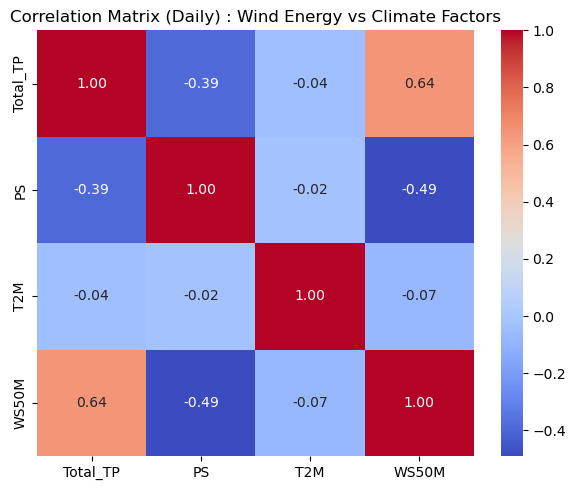

In [84]:
# Correlation Matrix: Wind Energy vs Climate Factors : Daily
plt.figure(figsize=(6,5))
corr = df_tmp_daily_corr.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Daily) : Wind Energy vs Climate Factors')
plt.tight_layout()
plt.show()

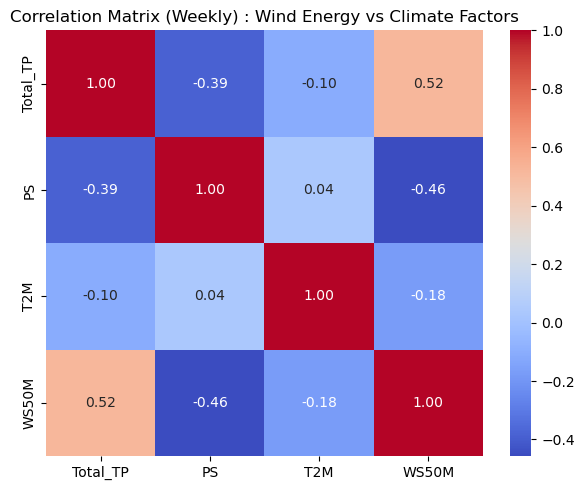

In [85]:
# Correlation Matrix: Wind Energy vs Climate Factors : Weekly
plt.figure(figsize=(6,5))
corr = df_tmp_wk_corr.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Weekly) : Wind Energy vs Climate Factors')
plt.tight_layout()
plt.show()

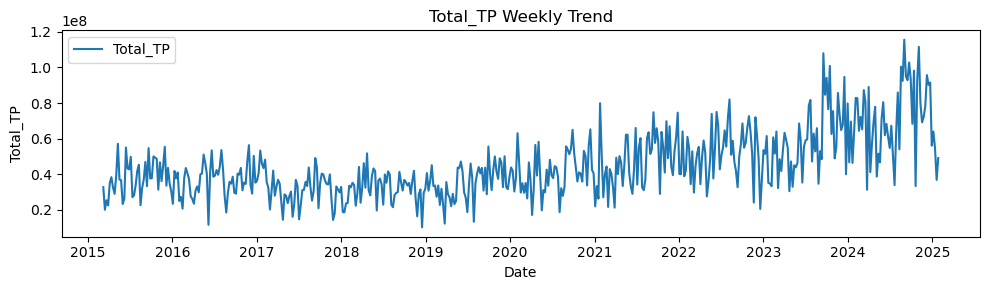

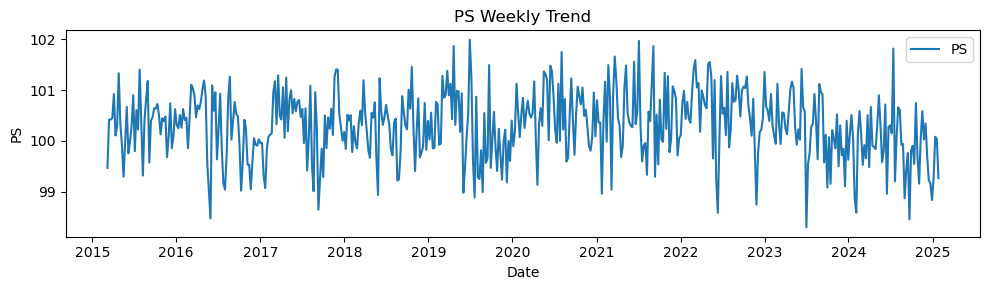

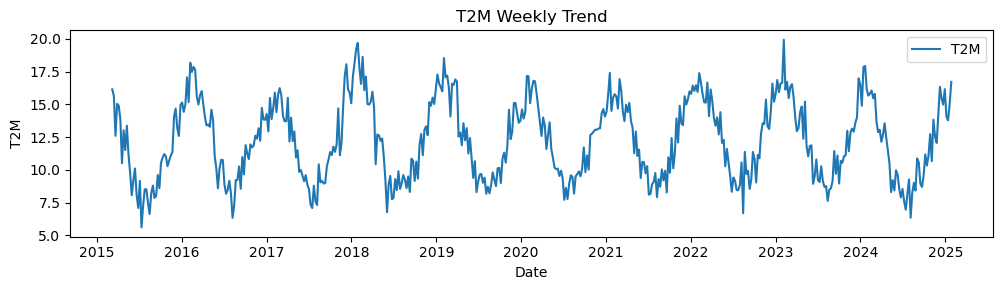

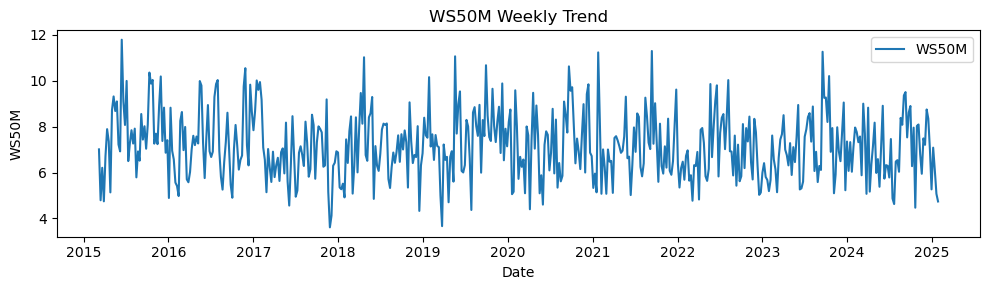

In [86]:
factors = ['Total_TP', 'PS'	,'T2M',	'WS50M']

for f in factors:
    plt.figure(figsize=(10, 3))
    plt.plot(df_tmp_wk_corr[f], label=f)
    plt.title(f'{f} Weekly Trend')
    plt.xlabel('Date')
    plt.ylabel(f)
    plt.legend()
    plt.tight_layout()
    plt.show()

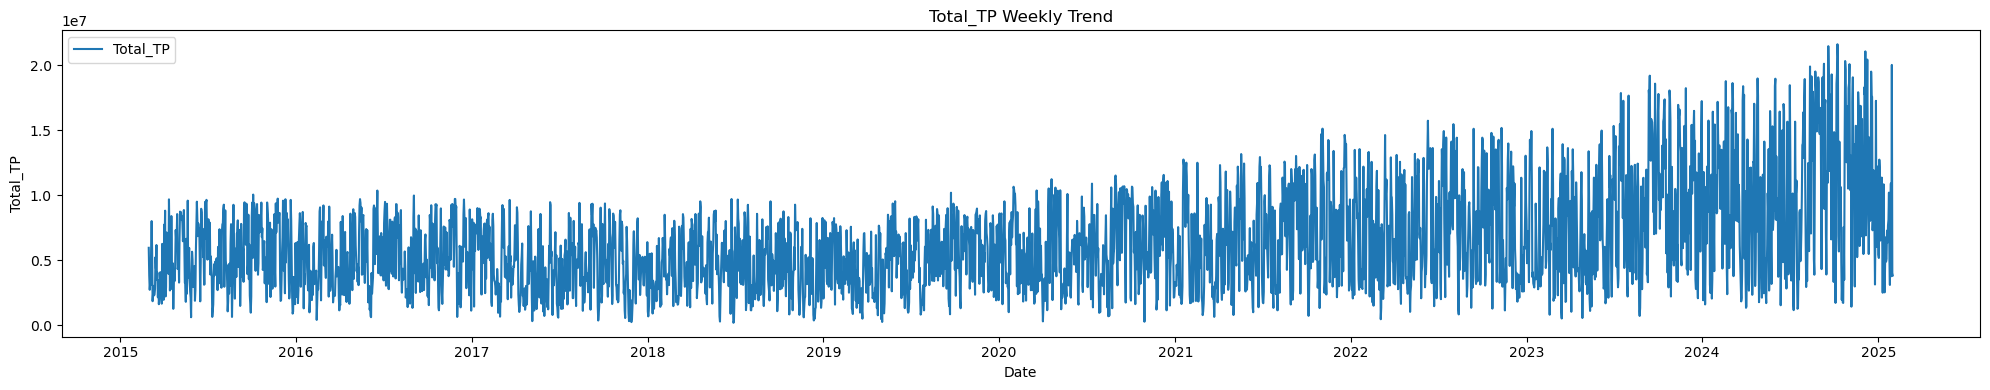

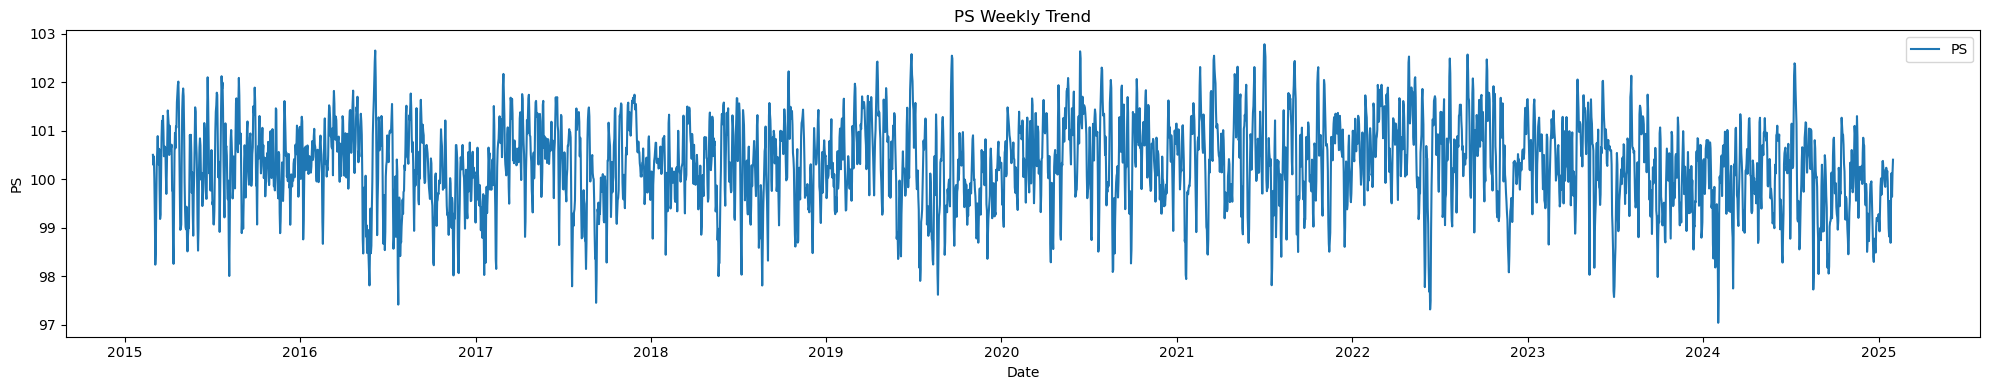

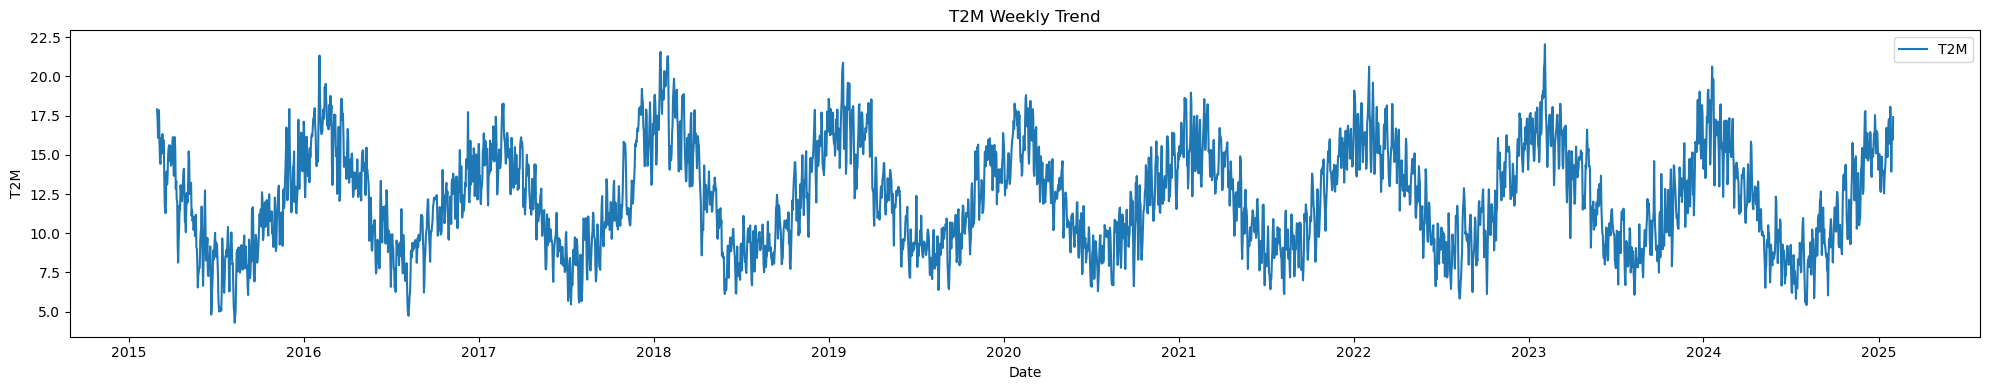

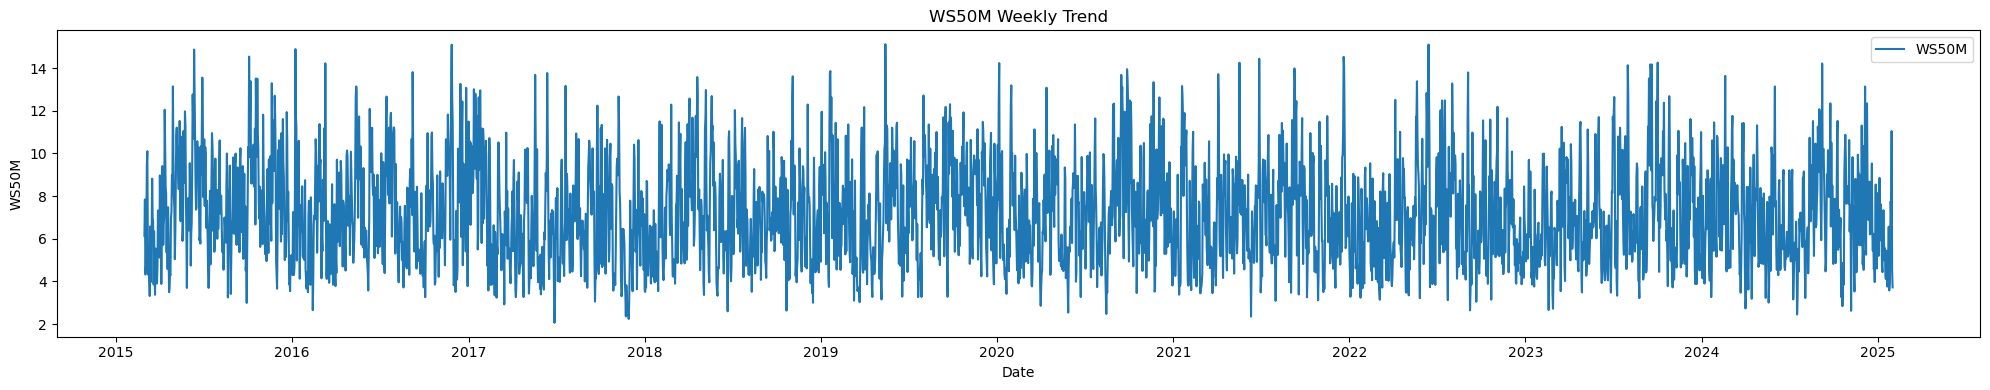

In [87]:
factors = ['Total_TP', 'PS'	,'T2M',	'WS50M']

for f in factors:
    plt.figure(figsize=(20,4))
    plt.plot(df_tmp_daily_corr[f], label=f)
    plt.title(f'{f} Weekly Trend')
    plt.xlabel('Date')
    plt.ylabel(f)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Start North Island

### North Island - Daily

In [90]:
df_island_north = df_island_daily[df_island_daily['Island'] == 'NI'].copy()

In [91]:
df_island_north.head()

Island      Total_TP          PS        T2M     WS50M
DATE                                                            
2015-03-01     NI  5.260841e+06  100.112857  19.091429  5.437143
2015-03-02     NI  3.153726e+06   99.978571  18.867143  7.068571
2015-03-03     NI  2.681721e+06   99.848571  19.025714  5.390000
2015-03-04     NI  2.780585e+06   99.504286  18.621429  4.620000
2015-03-05     NI  2.077977e+06   99.061429  19.682857  4.901429

In [92]:
df_island_north = df_island_north.drop(columns=['Island'])

In [93]:
df_island_north.head()

Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-01  5.260841e+06  100.112857  19.091429  5.437143
2015-03-02  3.153726e+06   99.978571  18.867143  7.068571
2015-03-03  2.681721e+06   99.848571  19.025714  5.390000
2015-03-04  2.780585e+06   99.504286  18.621429  4.620000
2015-03-05  2.077977e+06   99.061429  19.682857  4.901429

In [94]:
# stationery check for north island daily data
from statsmodels.tsa.stattools import adfuller

# Assume df_model_for_forecasting has a datetime index and a 'Total_TP' column.
result = adfuller(df_island_north['Total_TP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.380846
p-value: 0.000321
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [95]:
# Check for rows where Total_TP equals 0.0
zero_records = df_island_north[df_island_north['Total_TP'] == 0.0]
print("Number of weekly records with Total_TP equal to 0:", len(zero_records))
print(zero_records)

Number of weekly records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, PS, T2M, WS50M]
Index: []


In [96]:
df_island_north

Total_TP          PS        T2M      WS50M
DATE                                                      
2015-03-01  5.260841e+06  100.112857  19.091429   5.437143
2015-03-02  3.153726e+06   99.978571  18.867143   7.068571
2015-03-03  2.681721e+06   99.848571  19.025714   5.390000
2015-03-04  2.780585e+06   99.504286  18.621429   4.620000
2015-03-05  2.077977e+06   99.061429  19.682857   4.901429
...                  ...         ...        ...        ...
2025-01-27  1.001269e+07   99.494545  15.939091   7.677273
2025-01-28  3.096290e+06  100.591818  15.934545   4.301818
2025-01-29  1.884893e+07   99.961818  17.491818  10.261818
2025-01-30  3.862238e+06  100.158182  17.405455   4.907273
2025-01-31  3.647585e+06  100.412727  18.619091   4.700000

[3625 rows x 4 columns]

In [97]:
# # Ensure that 'DATE' is in datetime format
# df_island_north['DATE'] = pd.to_datetime(df_island_north['DATE'])

# # Set the 'DATE' column as the index
# df_island_north.set_index('DATE', inplace=True)

In [98]:
# Set frequency to daily
df_island_north = df_island_north.asfreq('D')

In [99]:
print(df_island_north.index.freq)

<Day>


In [100]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_island_north)
train_size = int(n * 0.8)
train_daily = df_island_north.iloc[:train_size]
test_daily = df_island_north.iloc[train_size:]

In [101]:
print("Daily Train set:", train_daily.index.min(), "to", train_daily.index.max())
print("Daily Test set:", test_daily.index.min(), "to", test_daily.index.max())

Daily Train set: 2015-03-01 00:00:00 to 2023-02-06 00:00:00
Daily Test set: 2023-02-07 00:00:00 to 2025-01-31 00:00:00


In [102]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_daily['Total_TP']
target_test = test_daily['Total_TP']


In [250]:

exog_cols = ['WS50M','T2M']
#exog_cols = ['WS50M']


In [252]:
exog_train = train_daily[exog_cols]
exog_test = test_daily[exog_cols]

In [254]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                exog=exog_train,
                order=(1, 1, 2),
                seasonal_order=(0, 0, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Total_TP   No. Observations:                 2900
Model:             SARIMAX(1, 1, 2)x(0, 0, [1], 7)   Log Likelihood              -44837.635
Date:                             Tue, 22 Apr 2025   AIC                          89689.271
Time:                                     20:41:44   BIC                          89731.052
Sample:                                 03-01-2015   HQIC                         89704.328
                                      - 02-06-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WS50M       8.913e+05   1.02e+04     87.460      0.000    8.71e+05    9.11e+05
T2M         2642.1853   1.4

In [ ]:
###############################################################################################3

In [212]:
from pmdarima import auto_arima

# Fit SARIMA model automatically with grid search
model = auto_arima(target_train,
                   exogenous=exog_train,  # Optional exogenous variables
                   seasonal=True,  # Use seasonal order
                   m=7,  # Weekly seasonality
                   trace=True,  # Show progress
                   stepwise=True,  # Efficient grid search
                   max_order=3,  # Limit maximum p/q orders to 3
                   max_d=2,  # Limit maximum differencing to 2
                   seasonal_order=(1, 1, 1, 7))  # Try seasonal components

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=93504.436, Time=3.03 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=94442.129, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=94312.990, Time=0.32 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=94004.623, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=94440.130, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=93503.321, Time=1.98 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=93504.736, Time=1.08 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=93496.563, Time=3.56 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=93497.957, Time=5.43 sec
 ARIMA(1,1,2)(0,0,2)[7] intercept   : AIC=93498.959, Time=2.55 sec
 ARIMA(2,1,1)(0,0,2)[7] intercept   : AIC=93535.878, Time=2.37 sec
 ARIMA(3,1,2)(0,0,2)[7] intercept   : AIC=93496.415, Time=4.68 sec
 ARIMA(3,1,2)(0,0,1)[7] intercept   : AIC=93503.226, Time=3.23 sec
 ARIMA(3,1,2)(1,0,2)[7] intercept   : AIC=93497.449, Time=6.83 sec
 ARIMA(3,1,2)(1,0,1

In [ ]:
# import itertools
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Define the parameter grid
# p = [0, 1, 2]  # AR terms (order for autoregressive)
# d = [0, 1]     # Differencing
# q = [0, 1, 2]  # MA terms (moving average)
# P = [0, 1]     # Seasonal AR terms
# D = [0, 1]     # Seasonal differencing terms
# Q = [0, 1]     # Seasonal MA terms
# S = [7, 30]    # Seasonal period (weekly = 7 days, monthly = 30 days)

# # Create the parameter combinations
# param_grid = list(itertools.product(p, d, q, P, D, Q, S))

# # Print the first 5 parameter combinations to check
# print(param_grid[:5])


In [ ]:
# import numpy as np

# # Initialize an empty list to store the results
# results = []

# # Loop over all parameter combinations
# for params in param_grid:
#     p, d, q, P, D, Q, S = params
    
#     # Fit the SARIMAX model for the current parameter combination
#     try:
#         model = SARIMAX(target_train,
#                         exog=exog_train,
#                         order=(p, d, q),
#                         seasonal_order=(P, D, Q, S),
#                         enforce_stationarity=False,
#                         enforce_invertibility=False)
        
#         # Fit the model and get the results
#         model_fit = model.fit(disp=False)
        
#         # Store the model's AIC (you can use other metrics as well)
#         results.append((params, model_fit.aic))
        
#     except Exception as e:
#         # Skip combinations that raise errors
#         print(f"Error with parameters {params}: {e}")
#         continue

# # Sort results by AIC
# results.sort(key=lambda x: x[1])

# # Display the best result
# print(f"Best Parameters: {results[0][0]}")
# print(f"Best AIC: {results[0][1]}")


In [256]:
# Forecast on the test set - non log
n_steps = len(test_daily)
forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [258]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("\nForecast Performance Metrics (Without Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (Without Log Transformation):
RMSE: 3766260.16
MAE: 2952114.89
Adjusted MAPE: 41.41%


In [ ]:
#
# exog_cols = ['WS50M']
# Forecast Performance Metrics (Without Log Transformation):
# RMSE: 273334.64
# MAE: 213157.34
# Adjusted MAPE: 33.02%
##########################################
# exog_cols = ['WS50M','PS']
# Forecast Performance Metrics (Without Log Transformation):
# RMSE: 277535.29
# MAE: 217705.17
# Adjusted MAPE: 33.91%

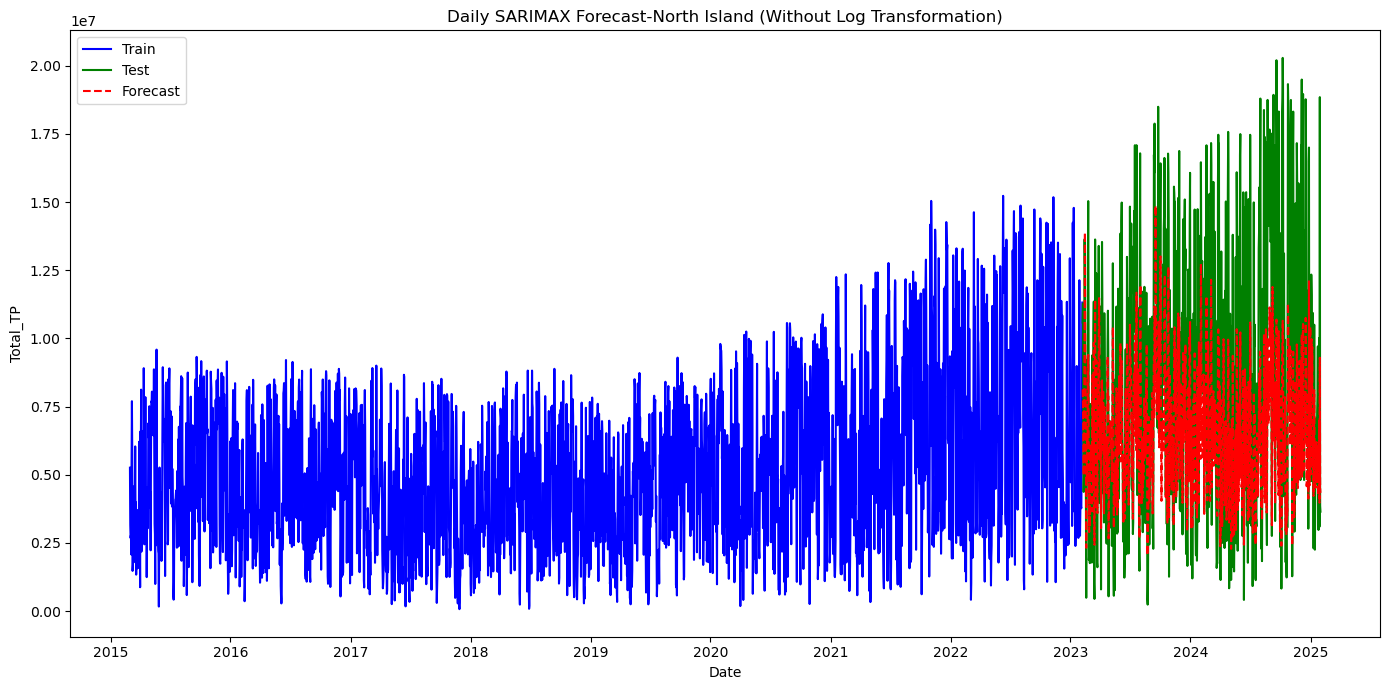

In [260]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_daily.index, target_train, label='Train', color='blue')
plt.plot(test_daily.index, target_test, label='Test', color='green')
plt.plot(test_daily.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Daily SARIMAX Forecast-North Island (Without Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

In [262]:
# # Create a log-transformed target. Adding 1 to avoid log(0) if needed.
df_island_north['Total_TP_log'] = np.log(df_island_north['Total_TP'] + 1)

In [264]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_island_north)
train_size = int(n * 0.8)
train_daily = df_island_north.iloc[:train_size]
test_daily = df_island_north.iloc[train_size:]

In [266]:
print("Daily Train set:", train_daily.index.min(), "to", train_daily.index.max())
print("Daily Test set:", test_daily.index.min(), "to", test_daily.index.max())

Daily Train set: 2015-03-01 00:00:00 to 2023-02-06 00:00:00
Daily Test set: 2023-02-07 00:00:00 to 2025-01-31 00:00:00


In [268]:
# Define the target variable (original Total_TP) and exogenous variables
target_train_log = train_daily['Total_TP_log']
target_test_log = test_daily['Total_TP_log']

# target_train = train_weekly['Total_TP']
# target_test = test_weekly['Total_TP']



In [270]:
exog_cols = ['WS50M']
#exog_cols = ['WS50M']


In [272]:
exog_train = train_daily[exog_cols]
exog_test = test_daily[exog_cols]

In [274]:
# Fit SARIMAX on the original (log) target data
model_log = SARIMAX(target_train_log,
                exog=exog_train,
                order=(1, 1, 2),
                seasonal_order=(0, 0, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)
results_log = model_log.fit(disp=False)
print(results_log.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        Total_TP_log   No. Observations:                 2900
Model:             SARIMAX(1, 1, 2)x(0, 0, [1], 7)   Log Likelihood               -1254.362
Date:                             Tue, 22 Apr 2025   AIC                           2520.724
Time:                                     20:43:16   BIC                           2556.536
Sample:                                 03-01-2015   HQIC                          2533.630
                                      - 02-06-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WS50M          0.2077      0.002     84.852      0.000       0.203       0.213
ar.L1          0.2364      

In [276]:
# Forecast on the test set
n_steps_log = len(test_daily)
forecast_log = results_log.get_forecast(steps=n_steps_log, exog=exog_test).predicted_mean

In [278]:
# Compute performance metrics
rmse = np.sqrt(mean_squared_error(target_test_log, forecast_log))
mae = mean_absolute_error(target_test_log, forecast_log)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test_log - forecast_log) / (target_test_log + epsilon))) * 100

print("\nForecast Performance Metrics (With Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (With Log Transformation):
RMSE: 0.47
MAE: 0.38
Adjusted MAPE: 2.45%


In [ ]:
"""
Forecast Performance Metrics (With Log Transformation):
RMSE: 0.47
MAE: 0.38
Adjusted MAPE: 2.45%

"""

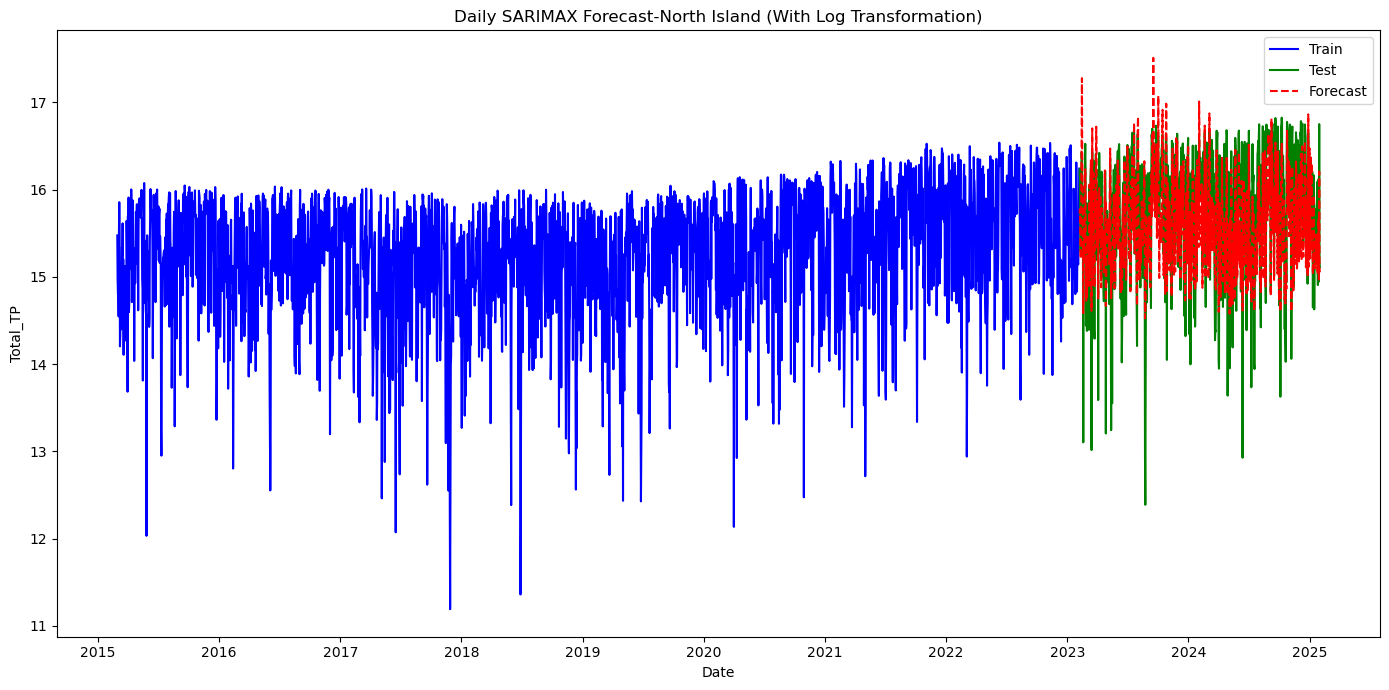

In [280]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_daily.index, target_train_log, label='Train', color='blue')
plt.plot(test_daily.index, target_test_log, label='Test', color='green')
plt.plot(test_daily.index, forecast_log, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Daily SARIMAX Forecast-North Island (With Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

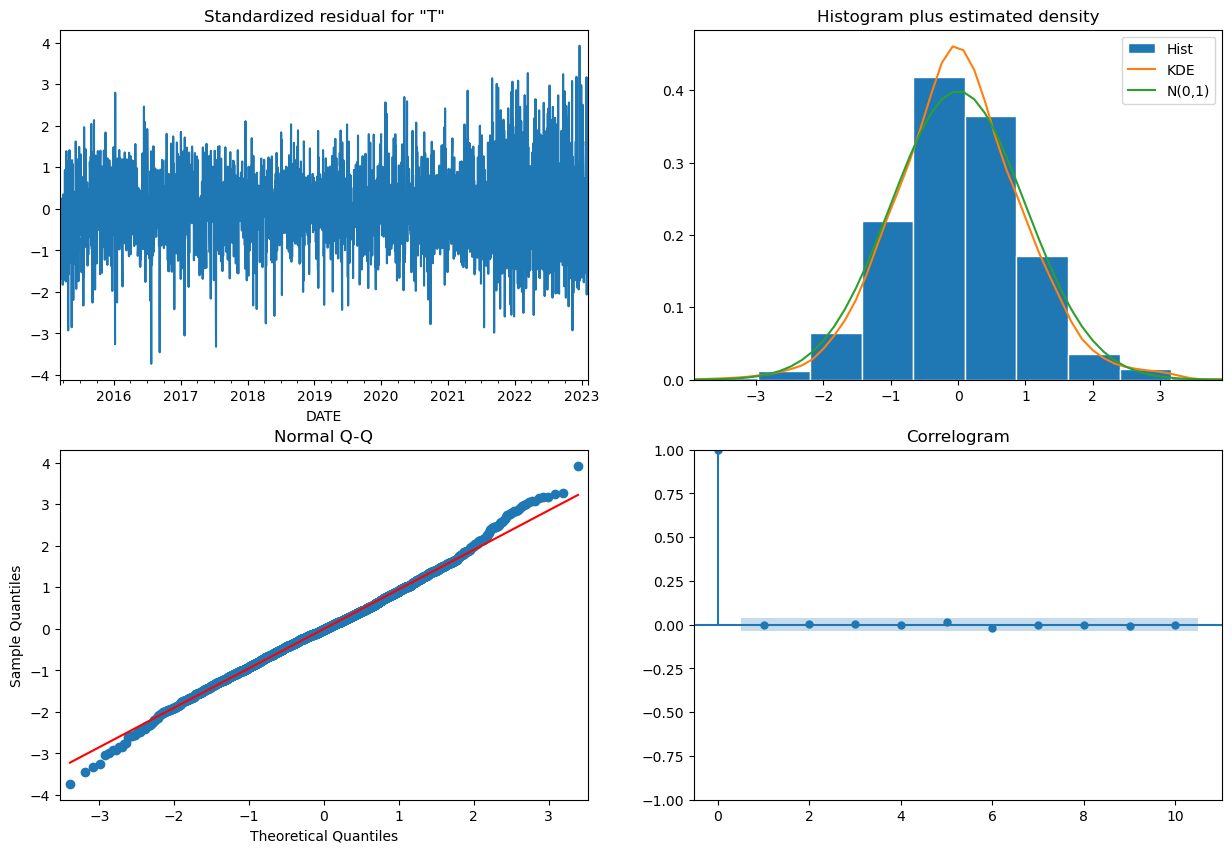

In [282]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

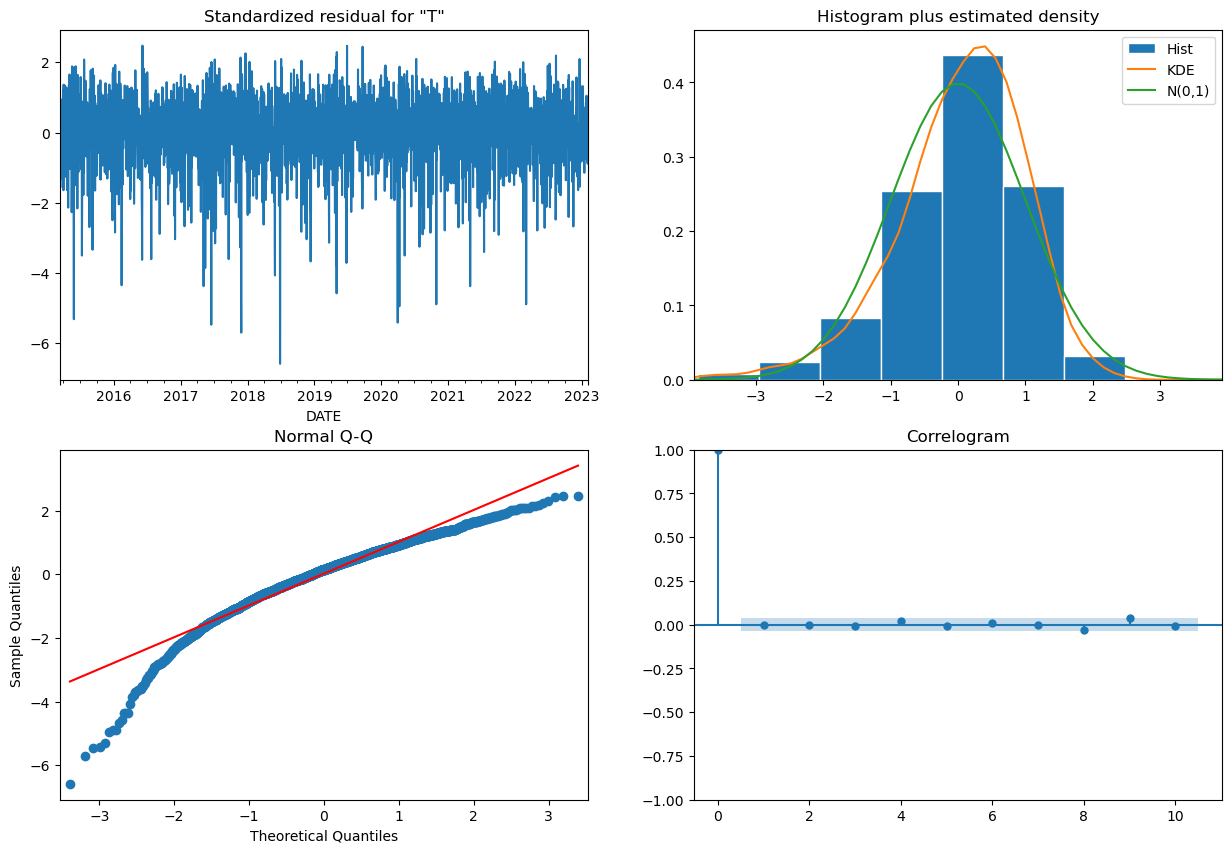

In [283]:
results_log.plot_diagnostics(figsize=(15, 10))
plt.show()

### North Island - Weekly analysis

In [286]:
df_island_north_wk = df_tmp_wk[df_tmp_wk['Island'] == 'NI'].copy()

In [288]:
df_island_north_wk = df_island_north_wk.drop(columns=['Island'])

In [290]:
df_tmp_wk

Island      Total_TP          PS        T2M     WS50M
DATE                                                            
2015-03-08     NI  2.970966e+07   99.060204  18.372449  7.480408
2015-03-15     NI  1.724348e+07   99.761224  17.476327  4.644694
2015-03-22     NI  2.317096e+07   99.580612  13.854694  7.118980
2015-03-29     NI  2.053256e+07   99.906531  16.650408  5.629796
2015-04-05     NI  3.000496e+07  100.376327  16.031224  6.114286
...           ...           ...         ...        ...       ...
2024-12-29     SI  1.924780e+06   98.870714  15.502143  3.909286
2025-01-05     SI  1.906796e+06   99.598571  12.987857  5.412857
2025-01-12     SI  2.494388e+06  100.256429  13.337143  5.043571
2025-01-19     SI  2.521028e+06  100.104286  14.891429  4.485000
2025-01-26     SI  2.017707e+06   99.272857  15.050000  3.810000

[1034 rows x 5 columns]

In [292]:
df_island_north_wk

Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-08  2.970966e+07   99.060204  18.372449  7.480408
2015-03-15  1.724348e+07   99.761224  17.476327  4.644694
2015-03-22  2.317096e+07   99.580612  13.854694  7.118980
2015-03-29  2.053256e+07   99.906531  16.650408  5.629796
2015-04-05  3.000496e+07  100.376327  16.031224  6.114286
...                  ...         ...        ...       ...
2024-12-29  5.410885e+07   98.810130  16.805844  6.629870
2025-01-05  6.205153e+07   98.957403  15.140000  8.763896
2025-01-12  5.210178e+07   99.909610  14.214545  7.200390
2025-01-19  3.425708e+07   99.968831  15.139870  5.665325
2025-01-26  4.706754e+07   99.268312  18.375844  5.674156

[517 rows x 4 columns]

In [294]:
# Step 3: Resample to weekly
# df_island_north_weekly = df_island_north.resample('W').mean()

In [296]:
# Find rows with zero Total_TP in South Island
zero_tp_north = df_island_north_wk[df_island_north_wk['Total_TP'] == 0]

# Get the unique dates
zero_dates = zero_tp_north.index.unique()

# Display the result
print("Dates with Total_TP = 0 in North Island:")
for date in zero_dates:
    print(date.strftime('%Y-%m-%d'))

Dates with Total_TP = 0 in North Island:


In [298]:
# stationery check for north island daily data
from statsmodels.tsa.stattools import adfuller

# Assume df_model_for_forecasting has a datetime index and a 'Total_TP' column.
result = adfuller(df_island_north_wk['Total_TP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.775324
p-value: 0.392780
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [300]:
# 1) First‐difference
y = df_island_north_wk['Total_TP']
y_diff = y.diff().dropna()

In [302]:
y_diff

DATE
2015-03-15   -1.246618e+07
2015-03-22    5.927471e+06
2015-03-29   -2.638394e+06
2015-04-05    9.472395e+06
2015-04-12    5.503496e+06
                  ...     
2024-12-29   -3.302393e+07
2025-01-05    7.942672e+06
2025-01-12   -9.949751e+06
2025-01-19   -1.784469e+07
2025-01-26    1.281046e+07
Name: Total_TP, Length: 516, dtype: float64

In [304]:
y 

DATE
2015-03-08    2.970966e+07
2015-03-15    1.724348e+07
2015-03-22    2.317096e+07
2015-03-29    2.053256e+07
2015-04-05    3.000496e+07
                  ...     
2024-12-29    5.410885e+07
2025-01-05    6.205153e+07
2025-01-12    5.210178e+07
2025-01-19    3.425708e+07
2025-01-26    4.706754e+07
Name: Total_TP, Length: 517, dtype: float64

In [306]:
# 3) Re‐run ADF on the differenced series
result = adfuller(y_diff)
print(f"ADF Statistic (1st diff): {result[0]:.6f}")
print(f"p‐value: {result[1]:.6f}")
for cv, val in result[4].items():
    print(f"   {cv} critical value: {val:.3f}")

ADF Statistic (1st diff): -12.280784
p‐value: 0.000000
   1% critical value: -3.443
   5% critical value: -2.867
   10% critical value: -2.570


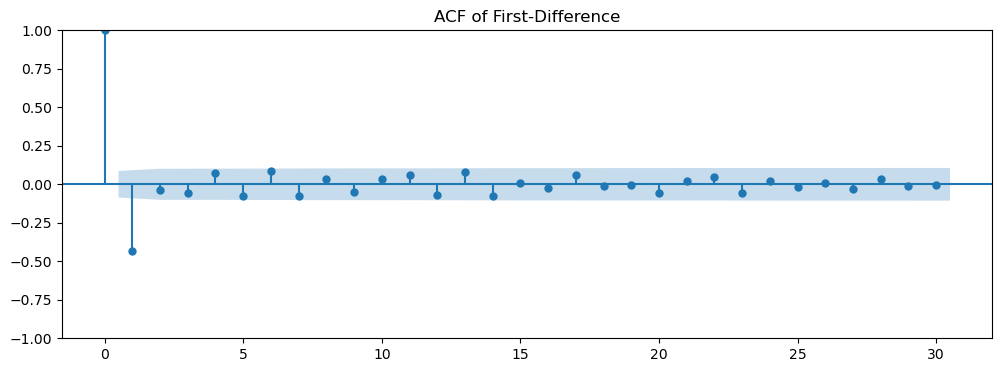

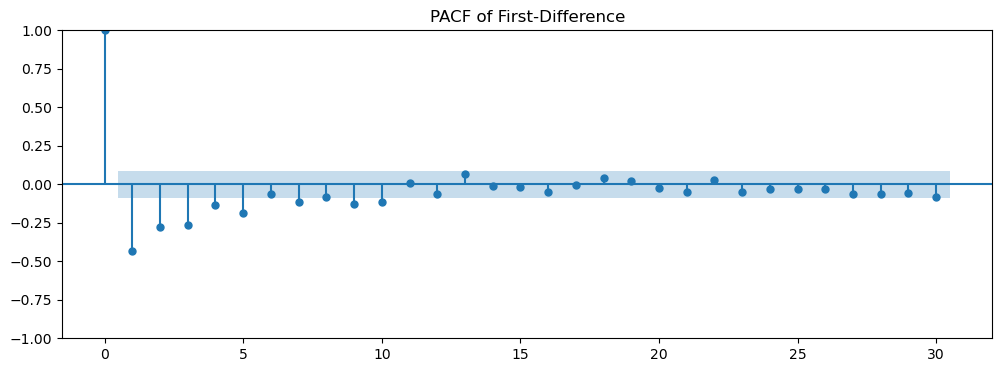

In [308]:
# 2) ACF / PACF plots to choose p and q
plt.figure(figsize=(12,4))
plot_acf(y_diff, lags=30, ax=plt.gca())
plt.title("ACF of First‐Difference")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(y_diff, lags=30, ax=plt.gca())
plt.title("PACF of First‐Difference")
plt.show()

In [312]:
# Check for rows where Total_TP equals 0.0
zero_records = df_island_north_wk[df_island_north_wk['Total_TP'] == 0.0]
print("Number of weekly records with Total_TP equal to 0:", len(zero_records))
print(zero_records)

Number of weekly records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, PS, T2M, WS50M]
Index: []


In [314]:
df_island_north_wk

Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-08  2.970966e+07   99.060204  18.372449  7.480408
2015-03-15  1.724348e+07   99.761224  17.476327  4.644694
2015-03-22  2.317096e+07   99.580612  13.854694  7.118980
2015-03-29  2.053256e+07   99.906531  16.650408  5.629796
2015-04-05  3.000496e+07  100.376327  16.031224  6.114286
...                  ...         ...        ...       ...
2024-12-29  5.410885e+07   98.810130  16.805844  6.629870
2025-01-05  6.205153e+07   98.957403  15.140000  8.763896
2025-01-12  5.210178e+07   99.909610  14.214545  7.200390
2025-01-19  3.425708e+07   99.968831  15.139870  5.665325
2025-01-26  4.706754e+07   99.268312  18.375844  5.674156

[517 rows x 4 columns]

# Train the model 

In [316]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_island_north_wk)
train_size = int(n * 0.8)
train_weekly = df_island_north_wk.iloc[:train_size]
test_weekly = df_island_north_wk.iloc[train_size:]

In [318]:
print("Weekly Train set:", train_weekly.index.min(), "to", train_weekly.index.max())
print("Weekly Test set:", test_weekly.index.min(), "to", test_weekly.index.max())

Weekly Train set: 2015-03-08 00:00:00 to 2023-01-29 00:00:00
Weekly Test set: 2023-02-05 00:00:00 to 2025-01-26 00:00:00


In [320]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_weekly['Total_TP']
target_test = test_weekly['Total_TP']


In [324]:

exog_cols = ['WS50M']
#exog_cols = ['WS50M']


In [326]:
exog_train = train_weekly[exog_cols]
exog_test = test_weekly[exog_cols]

In [334]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                exog=exog_train,
                order=(1, 1, 2),
                seasonal_order=(0, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                             Total_TP   No. Observations:                  413
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 52)   Log Likelihood               -5193.508
Date:                              Tue, 22 Apr 2025   AIC                          10399.015
Time:                                      20:51:10   BIC                          10421.337
Sample:                                  03-08-2015   HQIC                         10407.944
                                       - 01-29-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WS50M       5.829e+06   3.25e+05     17.913      0.000    5.19e+06    6.47e+06
ar.L1         -0.58

In [330]:
# Forecast on the test set - non log
n_steps = len(test_weekly)
forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [332]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("\nForecast Performance Metrics (Without Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (Without Log Transformation):
RMSE: 21622540.72
MAE: 17911947.66
Adjusted MAPE: 26.48%


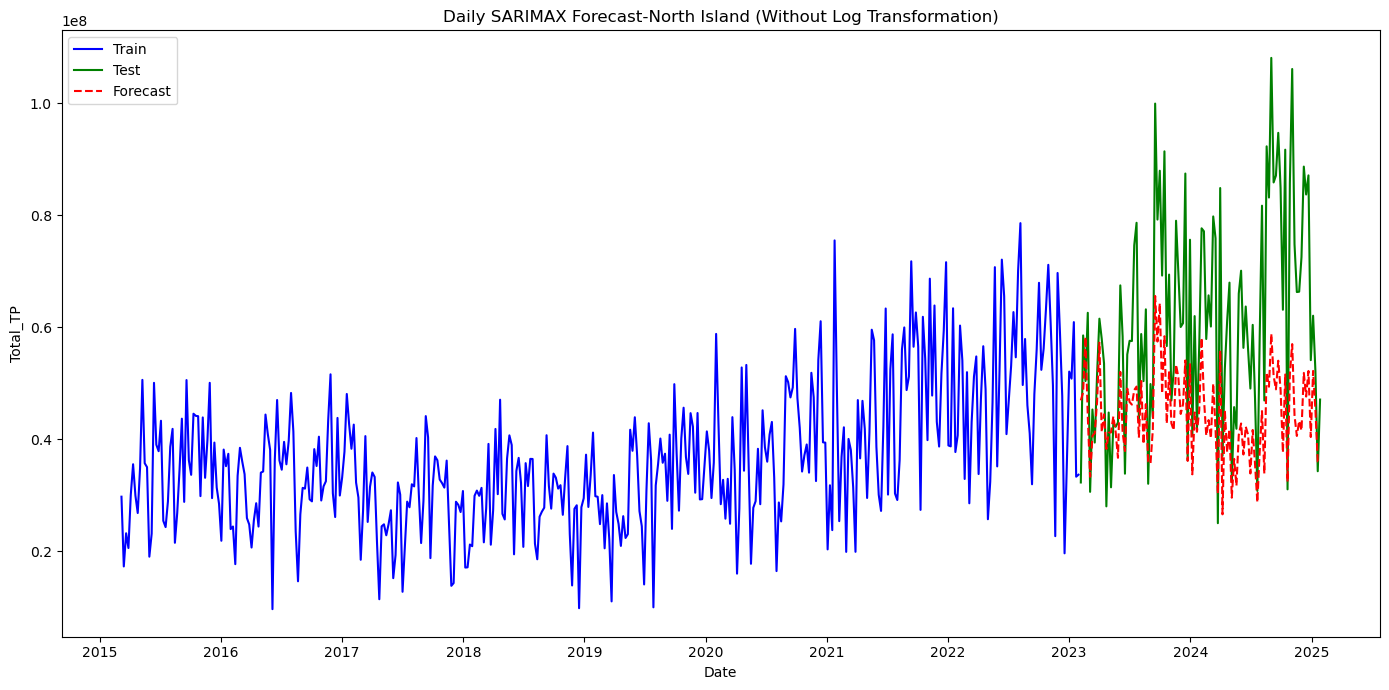

In [336]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_weekly.index, target_train, label='Train', color='blue')
plt.plot(test_weekly.index, target_test, label='Test', color='green')
plt.plot(test_weekly.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Daily SARIMAX Forecast-North Island (Without Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

In [338]:
# # Create a log-transformed target. Adding 1 to avoid log(0) if needed.
df_island_north_wk['Total_TP_log'] = np.log(df_island_north_wk['Total_TP'] + 1)

In [340]:
# Split the weekly data into 80% training and 20% testing sets
# n = len(df_island_north_weekly)
# train_size = int(n * 0.8)
# train_weekly = df_island_north.iloc[:train_size]
# test_weekly = df_island_north.iloc[train_size:]

# Split the weekly data into 80% training and 20% testing sets
n = len(df_island_north_wk)
train_size = int(n * 0.8)
train_weekly = df_island_north_wk.iloc[:train_size]
test_weekly = df_island_north_wk.iloc[train_size:]

In [342]:
print("Weekly Train set:", train_weekly.index.min(), "to", train_weekly.index.max())
print("Weekly Test set:", test_weekly.index.min(), "to", test_weekly.index.max())

Weekly Train set: 2015-03-08 00:00:00 to 2023-01-29 00:00:00
Weekly Test set: 2023-02-05 00:00:00 to 2025-01-26 00:00:00


In [344]:
# Define the target variable (original Total_TP) and exogenous variables
target_train_log = train_weekly['Total_TP_log']
target_test_log = test_weekly['Total_TP_log']

# target_train = train_weekly['Total_TP']
# target_test = test_weekly['Total_TP']



In [346]:
exog_cols = ['WS50M']
#exog_cols = ['WS50M']


In [348]:
exog_train = train_weekly[exog_cols]
exog_test = test_weekly[exog_cols]

In [350]:
# Fit SARIMAX on the original (log) target data
model_log = SARIMAX(target_train_log,
                exog=exog_train,
                order=(1, 1, 2),
                seasonal_order=(0, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results_log = model_log.fit(disp=False)
print(results_log.summary())

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                         Total_TP_log   No. Observations:                  413
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 52)   Log Likelihood                  90.962
Date:                              Tue, 22 Apr 2025   AIC                           -169.925
Time:                                      21:36:38   BIC                           -147.603
Sample:                                  03-08-2015   HQIC                          -160.997
                                       - 01-29-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WS50M          0.1825      0.006     32.745      0.000       0.172       0.193
ar.L1         -0.39

In [352]:
# Forecast on the test set
n_steps_log = len(test_weekly)
forecast_log = results_log.get_forecast(steps=n_steps_log, exog=exog_test).predicted_mean

In [354]:
# Compute performance metrics
rmse = np.sqrt(mean_squared_error(target_test_log, forecast_log))
mae = mean_absolute_error(target_test_log, forecast_log)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test_log - forecast_log) / (target_test_log + epsilon))) * 100

print("\nForecast Performance Metrics (With Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (With Log Transformation):
RMSE: 0.24
MAE: 0.21
Adjusted MAPE: 1.16%


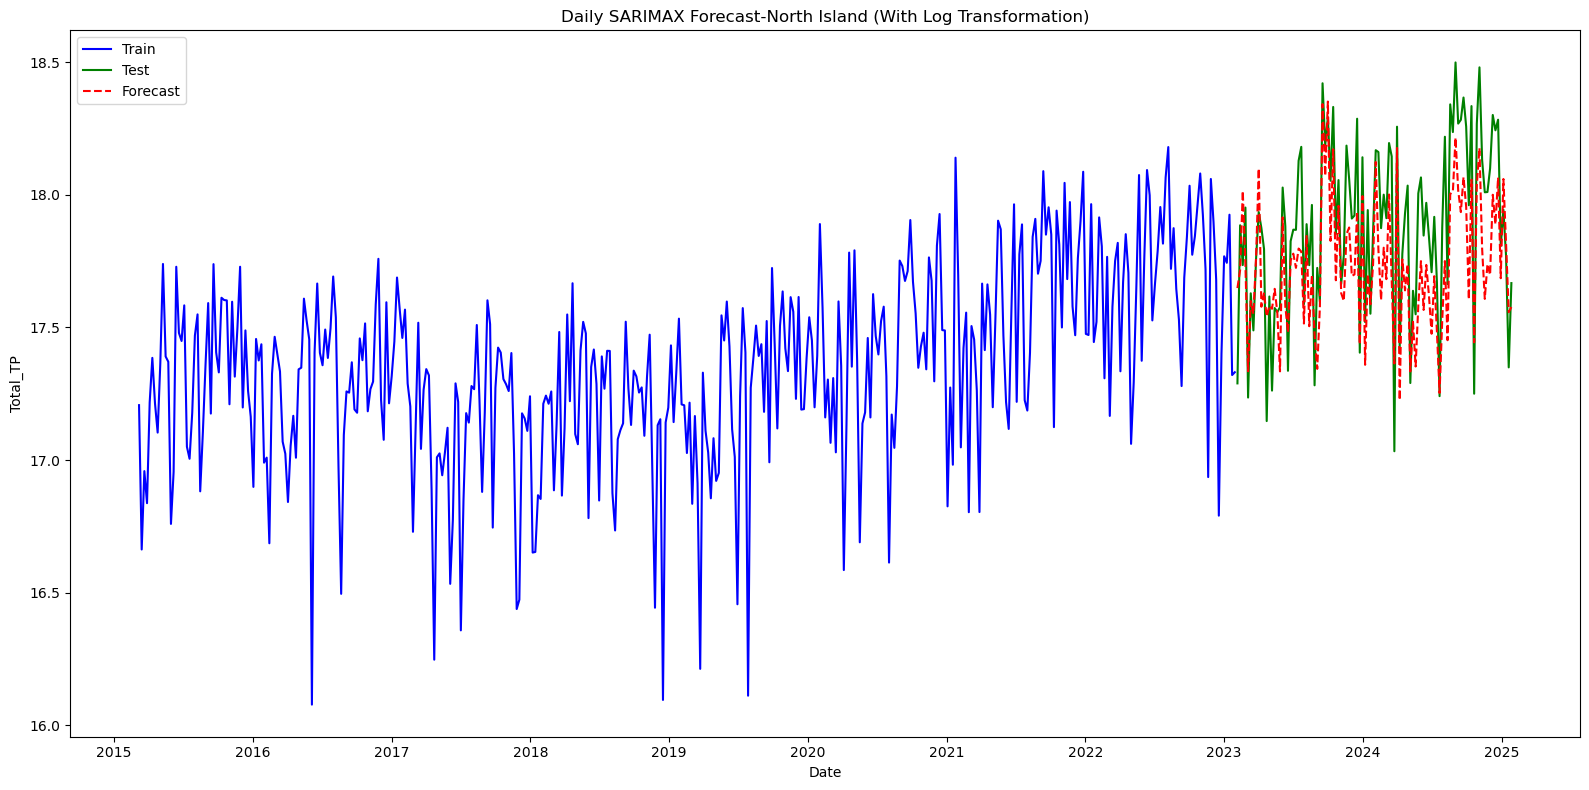

In [356]:
# Plot Actual vs. Forecast
plt.figure(figsize=(16, 8))
plt.plot(train_weekly.index, target_train_log, label='Train', color='blue')
plt.plot(test_weekly.index, target_test_log, label='Test', color='green')
plt.plot(test_weekly.index, forecast_log, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Daily SARIMAX Forecast-North Island (With Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

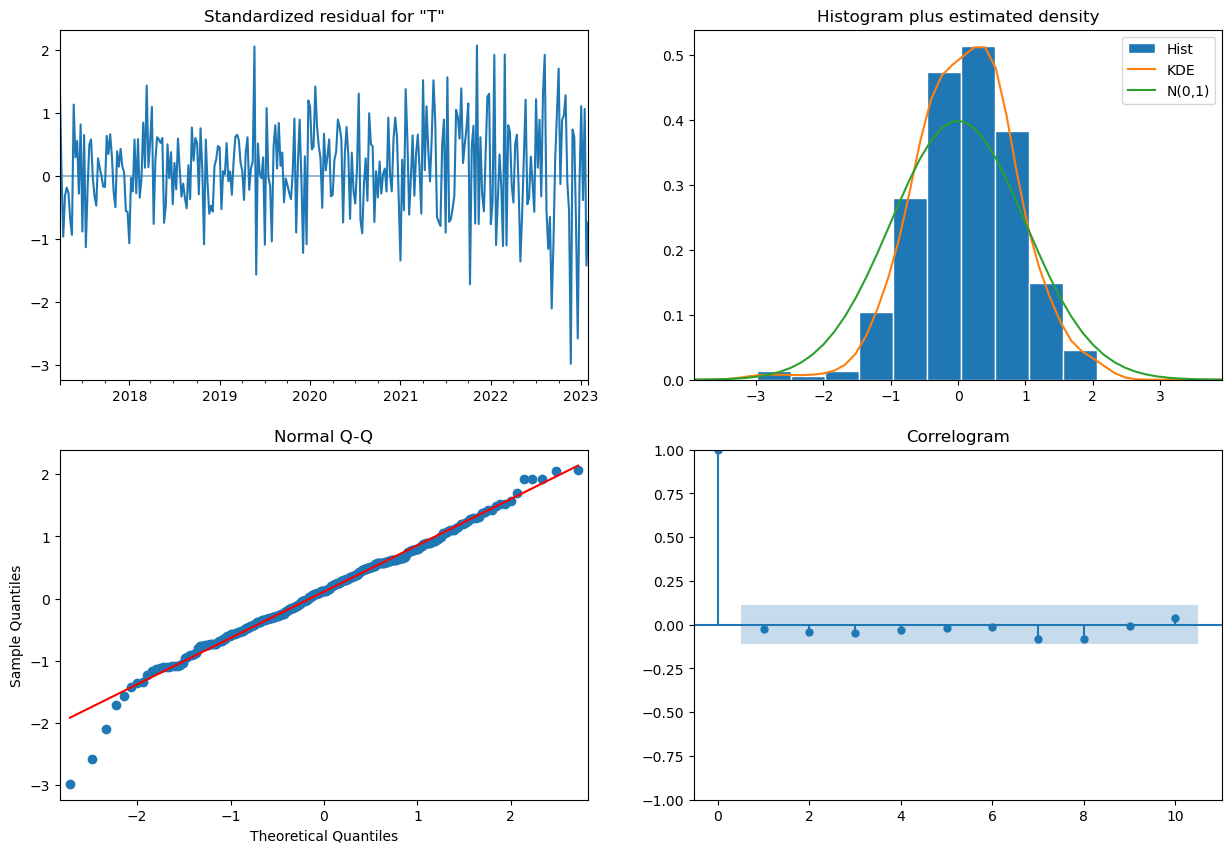

In [358]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

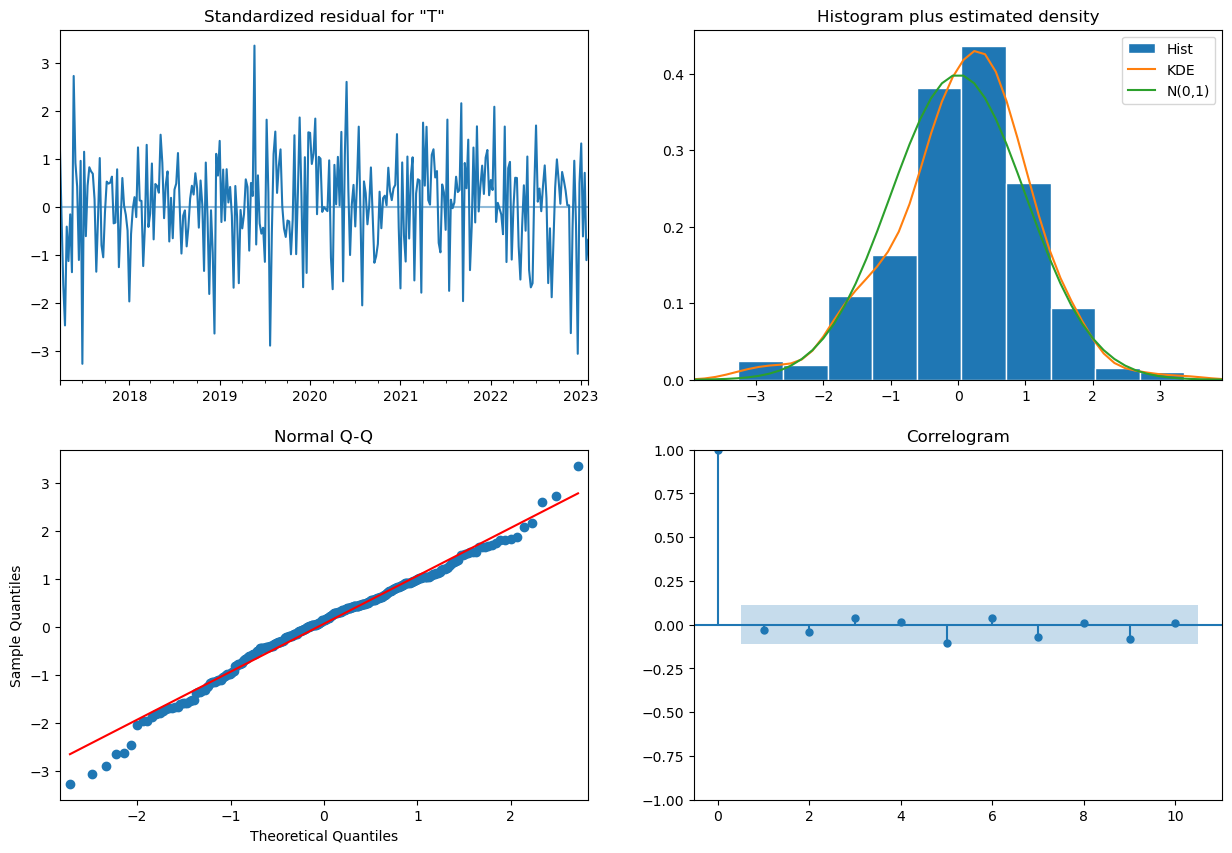

In [360]:
results_log.plot_diagnostics(figsize=(15, 10))
plt.show()

## End North Island

##  Start South Island

In [362]:
df_island_daily.tail(5)

Island   Total_TP       PS     T2M   WS50M
DATE                                                 
2025-01-27     SI   902222.0   99.810  11.910   7.825
2025-01-28     SI   674696.0   99.660  15.780   9.615
2025-01-29     SI  1188395.0   99.315  15.245  11.825
2025-01-30     SI   159300.0  100.095  14.505   4.120
2025-01-31     SI   185703.0  100.390  16.185   2.735

In [364]:
df_island_south = df_island_daily[df_island_daily['Island'] == 'SI'].copy()

In [366]:
df_island_south = df_island_south.drop(columns=['Island'])

In [368]:
df_island_south.head()

Total_TP      PS    T2M  WS50M
DATE                                          
2015-03-01  6.983304e+05  100.89  16.70   6.83
2015-03-02  6.893458e+05  100.61  15.76   8.61
2015-03-03  4.514572e+04  101.09  13.14   3.25
2015-03-04  4.422730e+05  100.52  14.89   4.82
2015-03-05  1.029295e+06   99.46  16.00   8.17

In [370]:
# Find rows with zero Total_TP in South Island
zero_tp_south = df_island_south[df_island_south['Total_TP'] == 0]

# Get the unique dates
zero_dates = zero_tp_south.index.unique()

# Display the result
print("Dates with Total_TP = 0 in South Island:")
for date in zero_dates:
    print(date.strftime('%Y-%m-%d'))

Dates with Total_TP = 0 in South Island:
2015-05-13
2015-05-14
2015-05-19
2015-05-20
2015-05-21
2015-10-29
2015-10-30
2017-06-02
2019-04-29
2019-04-30
2019-05-01
2019-05-02
2019-05-14
2020-11-10
2020-11-11
2020-11-12
2021-09-29
2023-06-07


If a zero actually means no generation (e.g., turbine was off), you might not want to interpolate—but if it’s a data artifact or gap, this is valid.

In [408]:
df_tmp_wk

Island      Total_TP          PS        T2M     WS50M
DATE                                                            
2015-03-08     NI  2.970966e+07   99.060204  18.372449  7.480408
2015-03-15     NI  1.724348e+07   99.761224  17.476327  4.644694
2015-03-22     NI  2.317096e+07   99.580612  13.854694  7.118980
2015-03-29     NI  2.053256e+07   99.906531  16.650408  5.629796
2015-04-05     NI  3.000496e+07  100.376327  16.031224  6.114286
...           ...           ...         ...        ...       ...
2024-12-29     SI  1.924780e+06   98.870714  15.502143  3.909286
2025-01-05     SI  1.906796e+06   99.598571  12.987857  5.412857
2025-01-12     SI  2.494388e+06  100.256429  13.337143  5.043571
2025-01-19     SI  2.521028e+06  100.104286  14.891429  4.485000
2025-01-26     SI  2.017707e+06   99.272857  15.050000  3.810000

[1034 rows x 5 columns]

In [430]:
df_island_south_wk

Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-08  2.978269e+06   99.881429  13.911429  6.545714
2015-03-15  2.755933e+06  101.075714  13.817143  4.945714
2015-03-22  2.169076e+06  101.260000  11.324286  5.302857
2015-03-29  1.893987e+06  100.988571  13.421429  3.867143
2015-04-05  4.960861e+06  101.465714  13.738571  7.328571
...                  ...         ...        ...       ...
2024-12-29  1.924780e+06   98.870714  15.502143  3.909286
2025-01-05  1.906796e+06   99.598571  12.987857  5.412857
2025-01-12  2.494388e+06  100.256429  13.337143  5.043571
2025-01-19  2.521028e+06  100.104286  14.891429  4.485000
2025-01-26  2.017707e+06   99.272857  15.050000  3.810000

[517 rows x 4 columns]

In [422]:
df_island_south_wk = df_tmp_wk[df_tmp_wk['Island'] == 'SI'].copy()

In [424]:
df_island_south_wk = df_island_south_wk.drop(columns=['Island'])

In [428]:
# Set frequency to daily
df_island_south_wk = df_island_south_wk.asfreq('W')

In [432]:
# Find rows with zero Total_TP in South Island
zero_tp_south = df_island_south_wk[df_island_south_wk['Total_TP'] == 0]

# Get the unique dates
zero_dates = zero_tp_south.index.unique()

# Display the result
print("Dates with Total_TP = 0 in South Island:")
for date in zero_dates:
    print(date.strftime('%Y-%m-%d'))

Dates with Total_TP = 0 in South Island:


In [434]:
# stationery check for north island daily data
from statsmodels.tsa.stattools import adfuller

# Assume df_model_for_forecasting has a datetime index and a 'Total_TP' column.
result = adfuller(df_island_south_wk['Total_TP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.819855
p-value: 0.055493
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [436]:
# 1) First‐difference
y = df_island_south_wk['Total_TP']
y_diff = y.diff().dropna()

In [438]:
y_diff

DATE
2015-03-15   -2.223360e+05
2015-03-22   -5.868568e+05
2015-03-29   -2.750885e+05
2015-04-05    3.066874e+06
2015-04-12   -2.164545e+06
                  ...     
2024-12-29   -2.493837e+06
2025-01-05   -1.798400e+04
2025-01-12    5.875920e+05
2025-01-19    2.664000e+04
2025-01-26   -5.033210e+05
Freq: W-SUN, Name: Total_TP, Length: 516, dtype: float64

In [440]:
# 3) Re‐run ADF on the differenced series
result = adfuller(y_diff)
print(f"ADF Statistic (1st diff): {result[0]:.6f}")
print(f"p‐value: {result[1]:.6f}")
for cv, val in result[4].items():
    print(f"   {cv} critical value: {val:.3f}")

ADF Statistic (1st diff): -11.219820
p‐value: 0.000000
   1% critical value: -3.443
   5% critical value: -2.867
   10% critical value: -2.570


In [442]:
# Check for rows where Total_TP equals 0.0
zero_records = df_island_south_wk[df_island_south_wk['Total_TP'] == 0.0]
print("Number of weekly records with Total_TP equal to 0:", len(zero_records))
print(zero_records)

Number of weekly records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, PS, T2M, WS50M]
Index: []


In [445]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_island_south_wk)
train_size = int(n * 0.8)
train_weekly = df_island_south_wk.iloc[:train_size]
test_weekly = df_island_south_wk.iloc[train_size:]

In [447]:
df_island_south_wk

Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-08  2.978269e+06   99.881429  13.911429  6.545714
2015-03-15  2.755933e+06  101.075714  13.817143  4.945714
2015-03-22  2.169076e+06  101.260000  11.324286  5.302857
2015-03-29  1.893987e+06  100.988571  13.421429  3.867143
2015-04-05  4.960861e+06  101.465714  13.738571  7.328571
...                  ...         ...        ...       ...
2024-12-29  1.924780e+06   98.870714  15.502143  3.909286
2025-01-05  1.906796e+06   99.598571  12.987857  5.412857
2025-01-12  2.494388e+06  100.256429  13.337143  5.043571
2025-01-19  2.521028e+06  100.104286  14.891429  4.485000
2025-01-26  2.017707e+06   99.272857  15.050000  3.810000

[517 rows x 4 columns]

In [449]:
print("Weekly Train set:", train_weekly.index.min(), "to", train_weekly.index.max())
print("Weekly Test set:", test_weekly.index.min(), "to", test_weekly.index.max())

Weekly Train set: 2015-03-08 00:00:00 to 2023-01-29 00:00:00
Weekly Test set: 2023-02-05 00:00:00 to 2025-01-26 00:00:00


In [451]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_weekly['Total_TP']
target_test = test_weekly['Total_TP']



In [453]:
exog_cols_wk = ['WS50M']
#exog_cols = ['WS50M']


In [455]:
exog_train = train_weekly[exog_cols_wk]
exog_test = test_weekly[exog_cols_wk]

In [457]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                exog=exog_train,
                order=(1, 1, 2),
                seasonal_order=(0, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             Total_TP   No. Observations:                  413
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 52)   Log Likelihood               -4623.225
Date:                              Tue, 22 Apr 2025   AIC                           9258.451
Time:                                      21:47:12   BIC                           9280.773
Sample:                                  03-08-2015   HQIC                          9267.379
                                       - 01-29-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WS50M       4.311e+05   4.87e+04      8.850      0.000    3.36e+05    5.27e+05
ar.L1         -0.99

In [459]:
# Forecast on the test set - non log
n_steps = len(test_weekly)
forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [461]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("\nForecast Performance Metrics (Without Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (Without Log Transformation):
RMSE: 3283569.47
MAE: 2741395.10
Adjusted MAPE: 54.91%


In [ ]:
print("Minimum of actual values in test set:", target_test.min())
print("Number of zeros in actual test set:", np.sum(target_test == 0))

In [ ]:
#
# exog_cols = ['WS50M']
# Forecast Performance Metrics (Without Log Transformation):
# RMSE: 273334.64
# MAE: 213157.34
# Adjusted MAPE: 33.02%
##########################################
# exog_cols = ['WS50M','PS']
# Forecast Performance Metrics (Without Log Transformation):
# RMSE: 277535.29
# MAE: 217705.17
# Adjusted MAPE: 33.91%

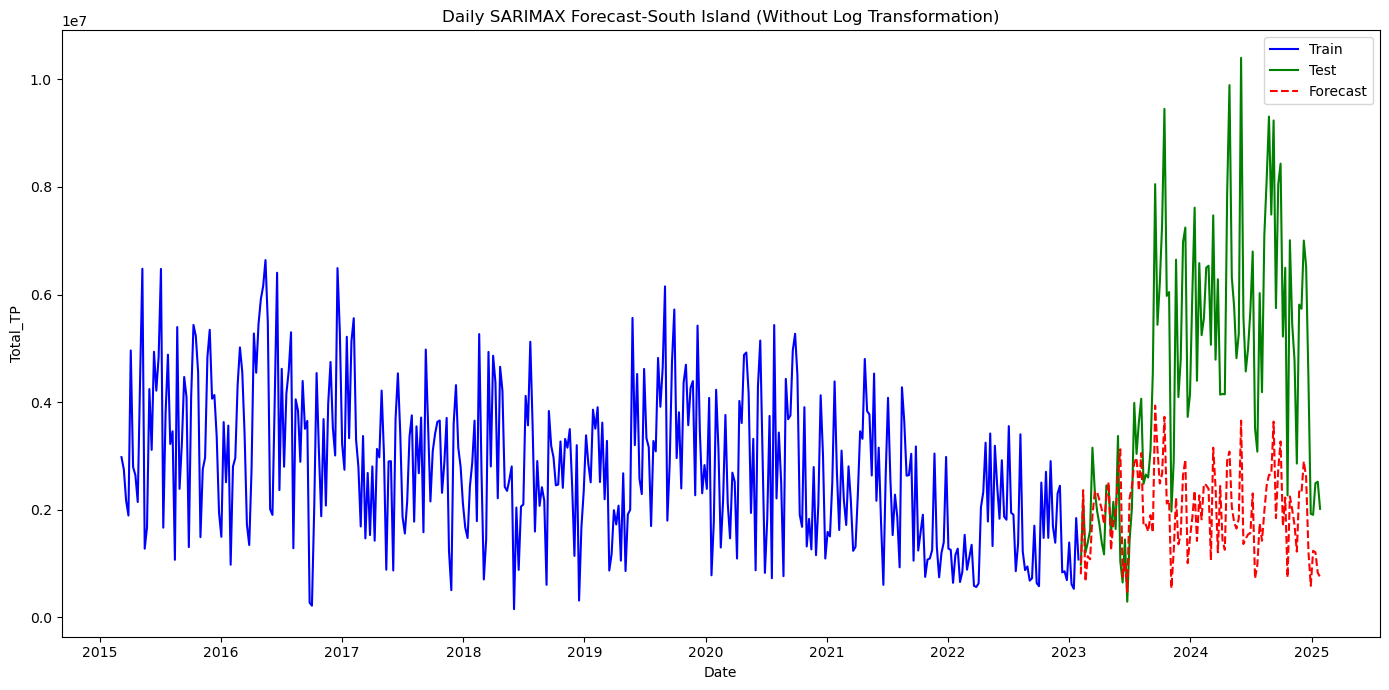

In [463]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_weekly.index, target_train, label='Train', color='blue')
plt.plot(test_weekly.index, target_test, label='Test', color='green')
plt.plot(test_weekly.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Daily SARIMAX Forecast-South Island (Without Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

In [465]:
# # Create a log-transformed target. Adding 1 to avoid log(0) if needed.
df_island_south_wk['Total_TP_log'] = np.log(df_island_south_wk['Total_TP'] + 1)

In [467]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_island_south_wk)
train_size = int(n * 0.8)
train_weekly = df_island_south_wk.iloc[:train_size]
test_weekly = df_island_south_wk.iloc[train_size:]

In [469]:
# Define the target variable (original Total_TP) and exogenous variables
target_train_log = train_weekly['Total_TP_log']
target_test_log = test_weekly['Total_TP_log']

# target_train = train_weekly['Total_TP']
# target_test = test_weekly['Total_TP']



In [471]:
exog_cols_wk = ['WS50M','PS']
#exog_cols = ['WS50M']


In [473]:
exog_train = train_weekly[exog_cols_wk]
exog_test = test_weekly[exog_cols_wk]

In [475]:
# Fit SARIMAX on the original (log) target data
model_log = SARIMAX(target_train_log,
                exog=exog_train,
                order=(1, 1, 2),
                seasonal_order=(0, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results_log = model_log.fit(disp=False)
print(results_log.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         Total_TP_log   No. Observations:                  413
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 52)   Log Likelihood                -188.231
Date:                              Tue, 22 Apr 2025   AIC                            390.461
Time:                                      21:48:36   BIC                            416.504
Sample:                                  03-08-2015   HQIC                           400.878
                                       - 01-29-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WS50M          0.2098      0.015     14.038      0.000       0.180       0.239
PS            -0.04

In [477]:
# Forecast on the test set
n_steps_log = len(test_weekly)
forecast_log = results_log.get_forecast(steps=n_steps_log, exog=exog_test).predicted_mean

In [479]:
# Compute performance metrics
rmse = np.sqrt(mean_squared_error(target_test_log, forecast_log))
mae = mean_absolute_error(target_test_log, forecast_log)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test_log - forecast_log) / (target_test_log + epsilon))) * 100

print("\nForecast Performance Metrics (With Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (With Log Transformation):
RMSE: 1.10
MAE: 1.00
Adjusted MAPE: 6.50%


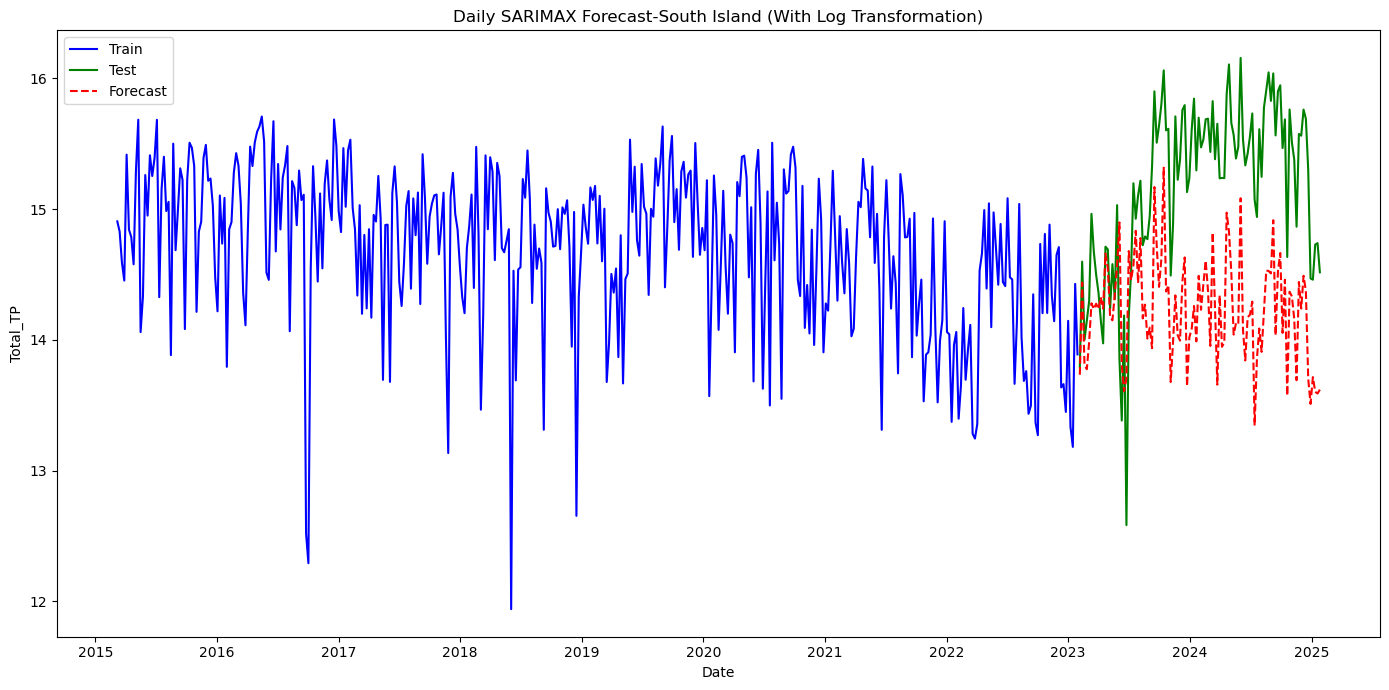

In [481]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_weekly.index, target_train_log, label='Train', color='blue')
plt.plot(test_weekly.index, target_test_log, label='Test', color='green')
plt.plot(test_weekly.index, forecast_log, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Daily SARIMAX Forecast-South Island (With Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

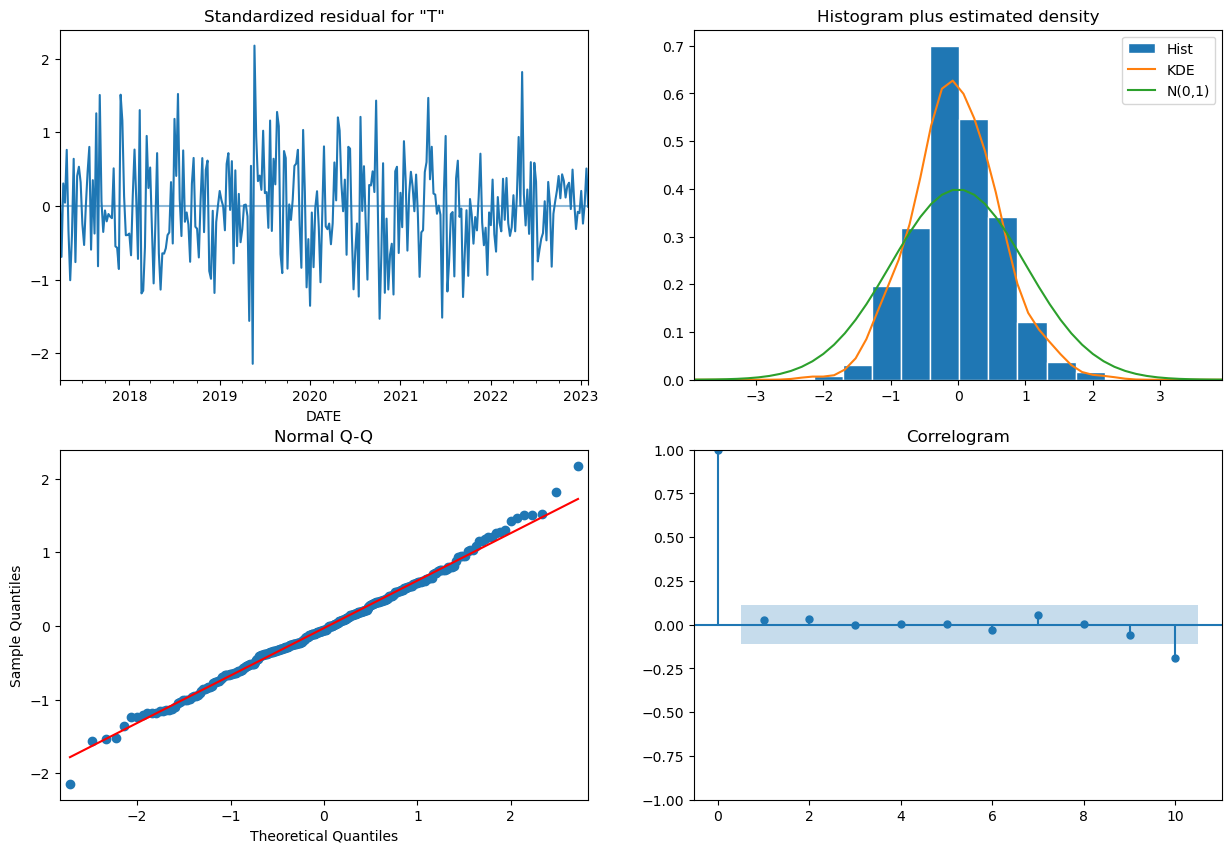

In [483]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

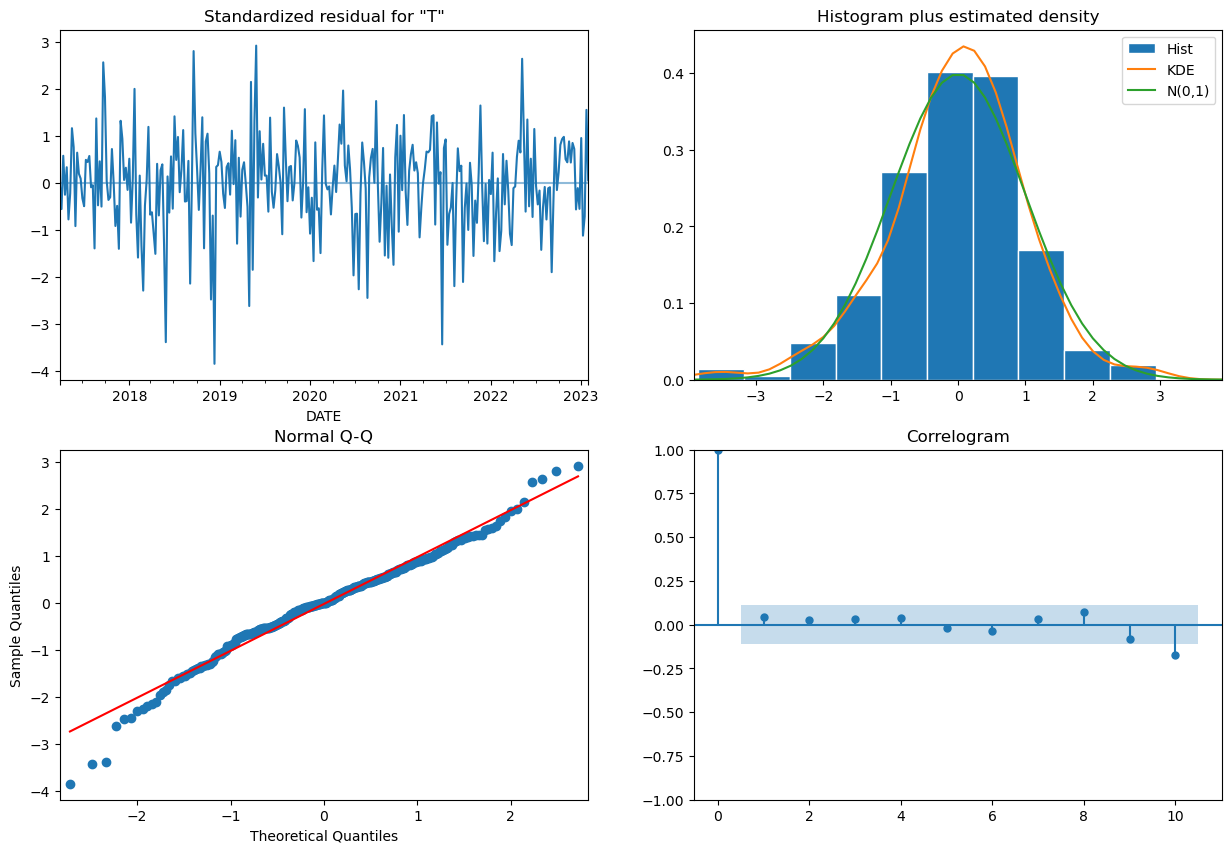

In [485]:
results_log.plot_diagnostics(figsize=(15, 10))
plt.show()

## Start - New Zealand

In [488]:
print(df_tmp_daily_corr.head())
print(df_tmp_wk_corr.head())

                Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-01  5.959171e+06  100.501429  17.895714  6.133571
2015-03-02  3.843072e+06  100.294286  17.313571  7.839286
2015-03-03  2.726867e+06  100.469286  16.082857  4.320000
2015-03-04  3.222858e+06  100.012143  16.755714  4.720000
2015-03-05  3.107272e+06   99.260714  17.841429  6.535714
                Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-08  3.268793e+07   99.470816  16.141939  7.013061
2015-03-15  1.999942e+07  100.418469  15.646735  4.795204
2015-03-22  2.534003e+07  100.420306  12.589490  6.210918
2015-03-29  2.242655e+07  100.447551  15.035918  4.748469
2015-04-05  3.496582e+07  100.921020  14.884898  6.721429


In [490]:
print(df_tmp_daily_corr.shape[0])

3625


In [492]:
print(df_tmp_daily_corr.head(4))

                Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-01  5.959171e+06  100.501429  17.895714  6.133571
2015-03-02  3.843072e+06  100.294286  17.313571  7.839286
2015-03-03  2.726867e+06  100.469286  16.082857  4.320000
2015-03-04  3.222858e+06  100.012143  16.755714  4.720000


In [494]:
print(df_tmp_wk_corr.shape[0])

517


In [496]:
print(df_tmp_wk_corr.head(4))

                Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-08  3.268793e+07   99.470816  16.141939  7.013061
2015-03-15  1.999942e+07  100.418469  15.646735  4.795204
2015-03-22  2.534003e+07  100.420306  12.589490  6.210918
2015-03-29  2.242655e+07  100.447551  15.035918  4.748469


In [498]:
# Find rows with zero Total_TP in South Island
zero_df_wind_nz = df_tmp_daily_corr[df_tmp_daily_corr['Total_TP'] == 0]

# Get the unique dates
zero_dates = zero_df_wind_nz.index.unique()

# Display the result
print("Dates with Total_TP = 0 in New Zealand:")
for date in zero_dates:
    print(date.strftime('%Y-%m-%d'))

Dates with Total_TP = 0 in New Zealand:


In [500]:
# stationery check for north island daily data
from statsmodels.tsa.stattools import adfuller

# Assume df_model_for_forecasting has a datetime index and a 'Total_TP' column.
result = adfuller(df_tmp_daily_corr['Total_TP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.553479
p-value: 0.000157
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [502]:
# Check for rows where Total_TP equals 0.0
zero_records = df_tmp_daily_corr[df_tmp_daily_corr['Total_TP'] == 0.0]
print("Number of weekly records with Total_TP equal to 0:", len(zero_records))
print(zero_records)

Number of weekly records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, PS, T2M, WS50M]
Index: []


In [504]:
# # stationery check for weekly data
# from statsmodels.tsa.stattools import adfuller

# # Assume df_model_for_forecasting has a datetime index and a 'Total_TP' column.
# result = adfuller(df_WWD1102_weekly['Total_TP'])
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))

# Train the model 

In [507]:
# Set frequency to daily
df_tmp_daily_corr = df_tmp_daily_corr.asfreq('D')

In [509]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_tmp_daily_corr)
train_size = int(n * 0.8)
train_daily = df_tmp_daily_corr.iloc[:train_size]
test_daily = df_tmp_daily_corr.iloc[train_size:]

In [511]:
print("Daily Train set:", train_daily.index.min(), "to", train_daily.index.max())
print("Daily Test set:", test_daily.index.min(), "to", test_daily.index.max())

Daily Train set: 2015-03-01 00:00:00 to 2023-02-06 00:00:00
Daily Test set: 2023-02-07 00:00:00 to 2025-01-31 00:00:00


In [513]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_daily['Total_TP']
target_test = test_daily['Total_TP']



In [525]:
exog_cols = ['WS50M']
#exog_cols = ['WS50M']


In [527]:
exog_train = train_daily[exog_cols]
exog_test = test_daily[exog_cols]

In [529]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                exog=exog_train,
                order=(1, 1, 2),
                seasonal_order=(0, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Total_TP   No. Observations:                 2900
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 7)   Log Likelihood              -45819.507
Date:                             Tue, 22 Apr 2025   AIC                          91651.014
Time:                                     21:51:30   BIC                          91686.811
Sample:                                 03-01-2015   HQIC                         91663.916
                                      - 02-06-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WS50M        9.51e+05   1.86e+04     51.190      0.000    9.15e+05    9.87e+05
ar.L1          0.0983      

In [530]:
# Forecast on the test set - non log
n_steps = len(test_daily)
forecast_daily = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [531]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast_daily))
mae = mean_absolute_error(target_test, forecast_daily)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("\nForecast Performance Metrics (Without Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (Without Log Transformation):
RMSE: 3773916.41
MAE: 3018142.73
Adjusted MAPE: 71.39%


In [535]:
#
# exog_cols = ['WS50M']
# Forecast Performance Metrics (Without Log Transformation):
# RMSE: 273334.64
# MAE: 213157.34
# Adjusted MAPE: 33.02%
##########################################
# exog_cols = ['WS50M','PS']
# Forecast Performance Metrics (Without Log Transformation):
# RMSE: 277535.29
# MAE: 217705.17
# Adjusted MAPE: 33.91%

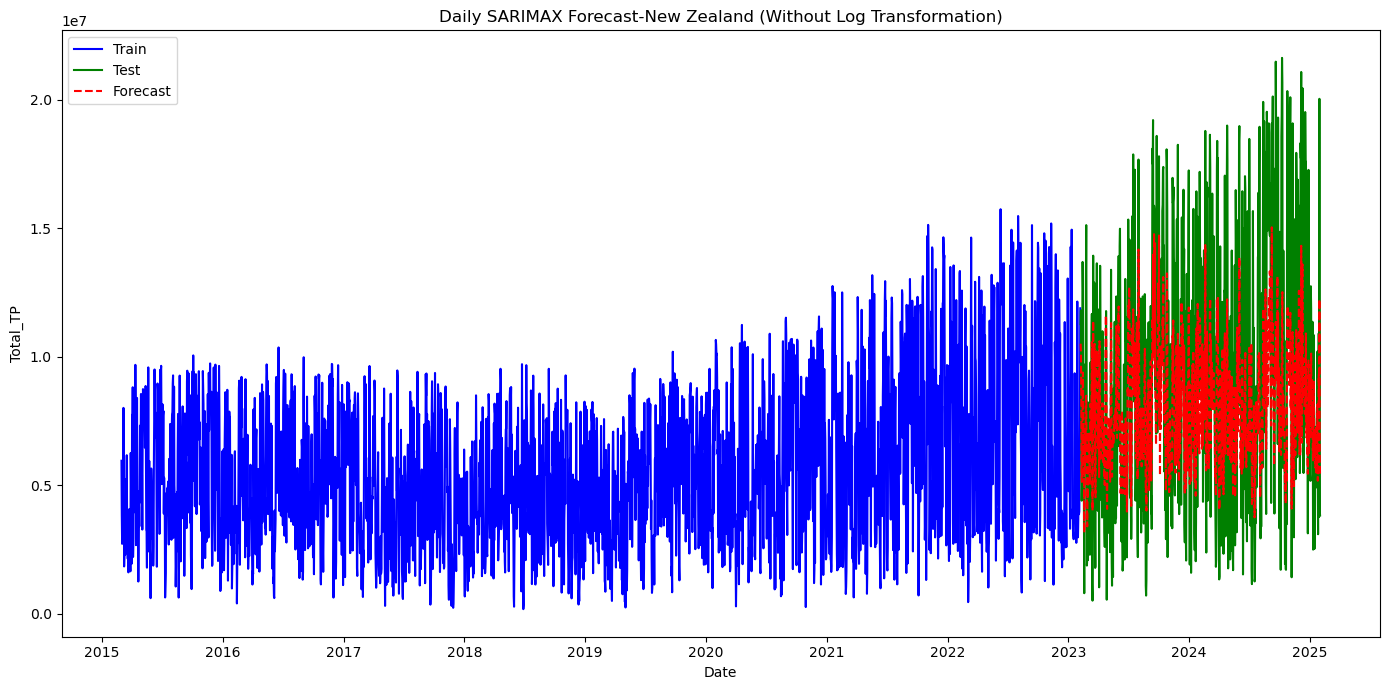

In [537]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_daily.index, target_train, label='Train', color='blue')
plt.plot(test_daily.index, target_test, label='Test', color='green')
plt.plot(test_daily.index, forecast_daily, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Daily SARIMAX Forecast-New Zealand (Without Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

In [539]:
# # Create a log-transformed target. Adding 1 to avoid log(0) if needed.
df_tmp_daily_corr['Total_TP_log'] = np.log(df_tmp_daily_corr['Total_TP'] + 1)

In [541]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_tmp_daily_corr)
train_size = int(n * 0.8)
train_daily = df_tmp_daily_corr.iloc[:train_size]
test_daily = df_tmp_daily_corr.iloc[train_size:]

In [543]:
print("Daily Train set:", train_daily.index.min(), "to", train_daily.index.max())
print("Daily Test set:", test_daily.index.min(), "to", test_daily.index.max())

Daily Train set: 2015-03-01 00:00:00 to 2023-02-06 00:00:00
Daily Test set: 2023-02-07 00:00:00 to 2025-01-31 00:00:00


In [545]:
# Define the target variable (original Total_TP) and exogenous variables
target_train_log = train_daily['Total_TP_log']
target_test_log = test_daily['Total_TP_log']

# target_train = train_weekly['Total_TP']
# target_test = test_weekly['Total_TP']



In [547]:
exog_cols = ['WS50M']
#exog_cols = ['WS50M']


In [549]:
exog_train = train_daily[exog_cols]
exog_test = test_daily[exog_cols]

In [551]:
# Fit SARIMAX on the original (log) target data
model_log = SARIMAX(target_train_log,
                exog=exog_train,
                order=(1, 1, 2),
                seasonal_order=(0, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)
results_log = model_log.fit(disp=False)
print(results_log.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        Total_TP_log   No. Observations:                 2900
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -1429.825
Date:                             Tue, 22 Apr 2025   AIC                           2871.649
Time:                                     21:52:26   BIC                           2907.447
Sample:                                 03-01-2015   HQIC                          2884.552
                                      - 02-06-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WS50M          0.1908      0.004     51.865      0.000       0.184       0.198
ar.L1          0.2418      

In [553]:
# Forecast on the test set
n_steps_log = len(test_daily)
forecast_log = results_log.get_forecast(steps=n_steps_log, exog=exog_test).predicted_mean

In [555]:
# Compute performance metrics
rmse = np.sqrt(mean_squared_error(target_test_log, forecast_log))
mae = mean_absolute_error(target_test_log, forecast_log)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test_log - forecast_log) / (target_test_log + epsilon))) * 100

print("\nForecast Performance Metrics (With Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (With Log Transformation):
RMSE: 0.45
MAE: 0.36
Adjusted MAPE: 2.31%


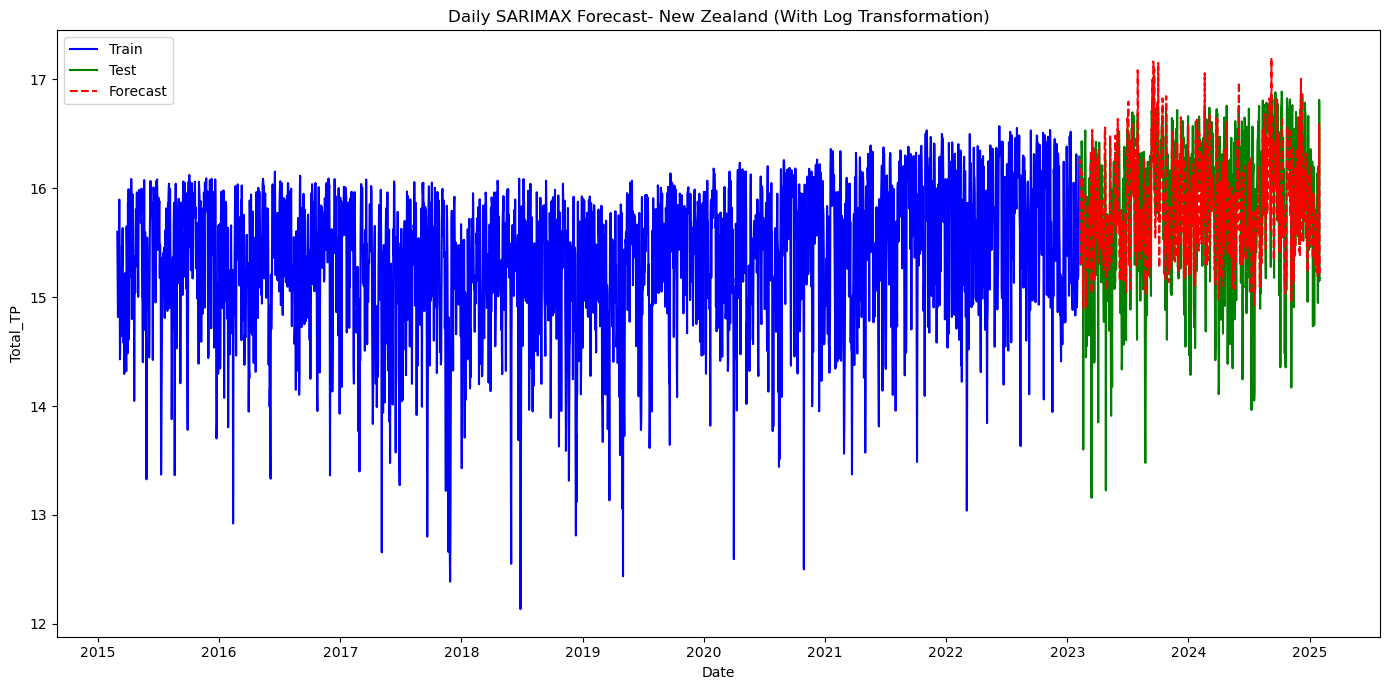

In [557]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_daily.index, target_train_log, label='Train', color='blue')
plt.plot(test_daily.index, target_test_log, label='Test', color='green')
plt.plot(test_daily.index, forecast_log, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Daily SARIMAX Forecast- New Zealand (With Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

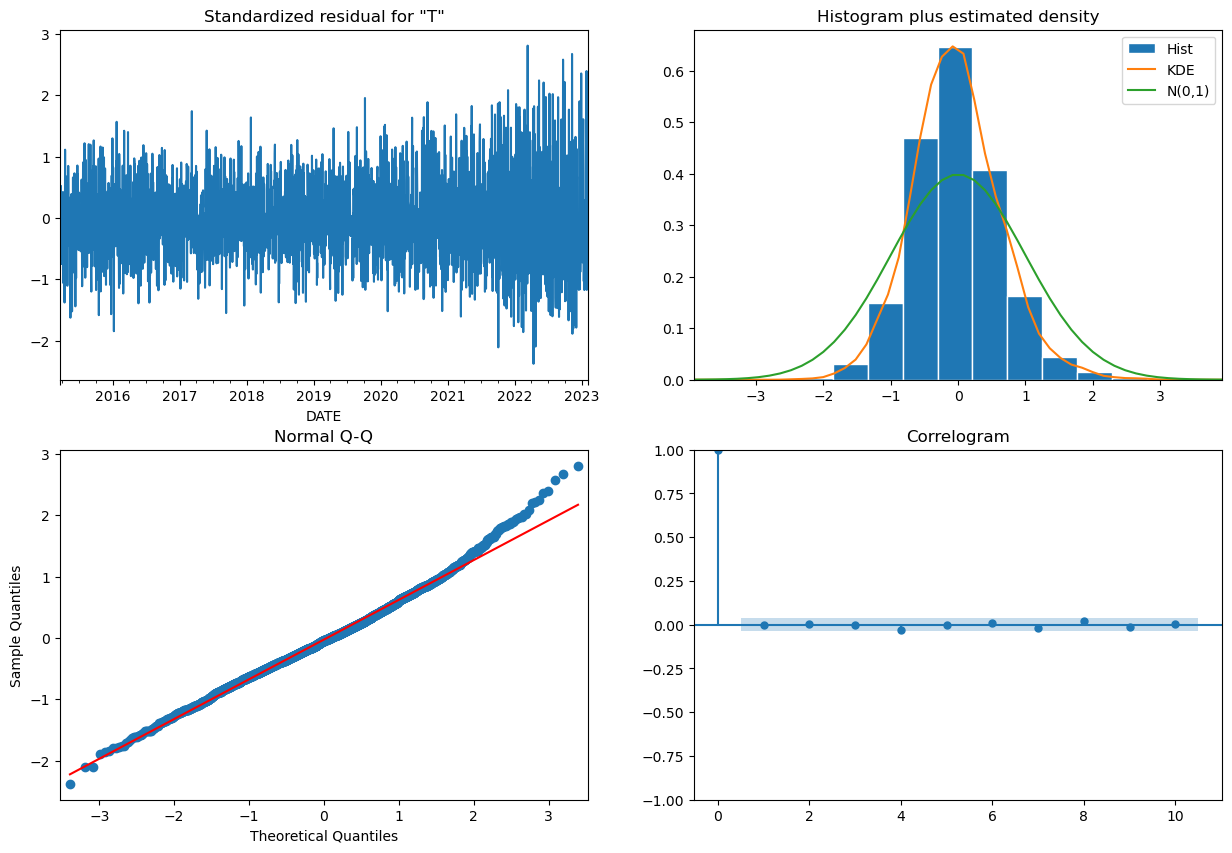

In [559]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

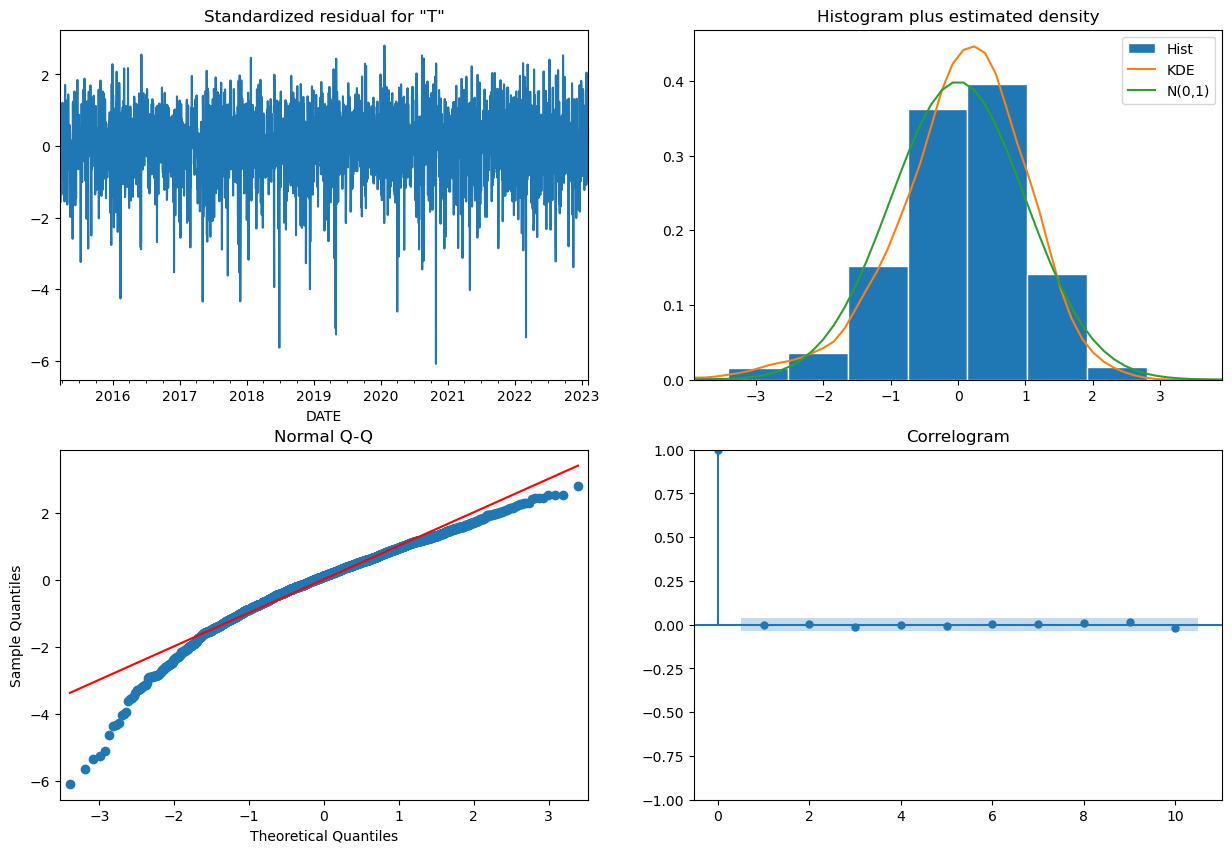

In [561]:
results_log.plot_diagnostics(figsize=(15, 10))
plt.show()

### Weekly analysis - New Zealand

In [563]:
# Step 3: Resample to weekly
df_tmp_wk_corr

Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-08  3.268793e+07   99.470816  16.141939  7.013061
2015-03-15  1.999942e+07  100.418469  15.646735  4.795204
2015-03-22  2.534003e+07  100.420306  12.589490  6.210918
2015-03-29  2.242655e+07  100.447551  15.035918  4.748469
2015-04-05  3.496582e+07  100.921020  14.884898  6.721429
...                  ...         ...        ...       ...
2024-12-29  5.603363e+07   98.840422  16.153994  5.269578
2025-01-05  6.395832e+07   99.277987  14.063929  7.088377
2025-01-12  5.459616e+07  100.083019  13.775844  6.121981
2025-01-19  3.677811e+07  100.036558  15.015649  5.075162
2025-01-26  4.908525e+07   99.270584  16.712922  4.742078

[517 rows x 4 columns]

In [565]:
# Set frequency to daily
df_tmp_wk_corr = df_tmp_wk_corr.asfreq('W')

In [567]:
# Find rows with zero Total_TP in South Island
zero_tp_nz = df_tmp_wk_corr[df_tmp_wk_corr['Total_TP'] == 0]

# Get the unique dates
zero_dates = zero_tp_nz.index.unique()

# Display the result
print("Dates with Total_TP = 0 in South Island:")
for date in zero_dates:
    print(date.strftime('%Y-%m-%d'))

Dates with Total_TP = 0 in South Island:


In [569]:
# stationery check for north island daily data
from statsmodels.tsa.stattools import adfuller

# Assume df_model_for_forecasting has a datetime index and a 'Total_TP' column.
result = adfuller(df_tmp_wk_corr['Total_TP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.857990
p-value: 0.352075
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [571]:
# 1) First‐difference
y = df_tmp_wk_corr['Total_TP']
y_diff = y.diff().dropna()

In [573]:
# 3) Re‐run ADF on the differenced series
result = adfuller(y_diff)
print(f"ADF Statistic (1st diff): {result[0]:.6f}")
print(f"p‐value: {result[1]:.6f}")
for cv, val in result[4].items():
    print(f"   {cv} critical value: {val:.3f}")

ADF Statistic (1st diff): -12.251832
p‐value: 0.000000
   1% critical value: -3.443
   5% critical value: -2.867
   10% critical value: -2.570


In [575]:
# Check for rows where Total_TP equals 0.0
zero_records = df_tmp_wk_corr[df_tmp_wk_corr['Total_TP'] == 0.0]
print("Number of weekly records with Total_TP equal to 0:", len(zero_records))
print(zero_records)

Number of weekly records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, PS, T2M, WS50M]
Index: []


In [577]:
df_tmp_wk_corr

Total_TP          PS        T2M     WS50M
DATE                                                     
2015-03-08  3.268793e+07   99.470816  16.141939  7.013061
2015-03-15  1.999942e+07  100.418469  15.646735  4.795204
2015-03-22  2.534003e+07  100.420306  12.589490  6.210918
2015-03-29  2.242655e+07  100.447551  15.035918  4.748469
2015-04-05  3.496582e+07  100.921020  14.884898  6.721429
...                  ...         ...        ...       ...
2024-12-29  5.603363e+07   98.840422  16.153994  5.269578
2025-01-05  6.395832e+07   99.277987  14.063929  7.088377
2025-01-12  5.459616e+07  100.083019  13.775844  6.121981
2025-01-19  3.677811e+07  100.036558  15.015649  5.075162
2025-01-26  4.908525e+07   99.270584  16.712922  4.742078

[517 rows x 4 columns]

In [579]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_tmp_wk_corr)
train_size = int(n * 0.8)
train_weekly = df_tmp_wk_corr.iloc[:train_size]
test_weekly = df_tmp_wk_corr.iloc[train_size:]

In [581]:
print("Weekly Train set:", train_weekly.index.min(), "to", train_weekly.index.max())
print("Weekly Test set:", test_weekly.index.min(), "to", test_weekly.index.max())

Weekly Train set: 2015-03-08 00:00:00 to 2023-01-29 00:00:00
Weekly Test set: 2023-02-05 00:00:00 to 2025-01-26 00:00:00


In [583]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_weekly['Total_TP']
target_test = test_weekly['Total_TP']


In [585]:

exog_cols = ['WS50M','PS']
#exog_cols = ['WS50M']


In [587]:
exog_train = train_weekly[exog_cols]
exog_test = test_weekly[exog_cols]

In [589]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                exog=exog_train,
                order=(1, 1, 2),
                seasonal_order=(0, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             Total_TP   No. Observations:                  413
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 52)   Log Likelihood               -5264.712
Date:                              Tue, 22 Apr 2025   AIC                          10543.424
Time:                                      21:54:36   BIC                          10569.467
Sample:                                  03-08-2015   HQIC                         10553.841
                                       - 01-29-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WS50M       5.749e+06   3.71e+05     15.502      0.000    5.02e+06    6.48e+06
PS         -4.699e+

In [591]:
# Forecast on the test set - non log
n_steps = len(test_weekly)
forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [593]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("\nForecast Performance Metrics (Without Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (Without Log Transformation):
RMSE: 15290465.36
MAE: 12301582.53
Adjusted MAPE: 18.42%


In [ ]:
print("Minimum of actual values in test set:", target_test.min())
print("Number of zeros in actual test set:", np.sum(target_test == 0))

In [ ]:
#
# exog_cols = ['WS50M']
# Forecast Performance Metrics (Without Log Transformation):
# RMSE: 273334.64
# MAE: 213157.34
# Adjusted MAPE: 33.02%
##########################################
# exog_cols = ['WS50M','PS']
# Forecast Performance Metrics (Without Log Transformation):
# RMSE: 277535.29
# MAE: 217705.17
# Adjusted MAPE: 33.91%

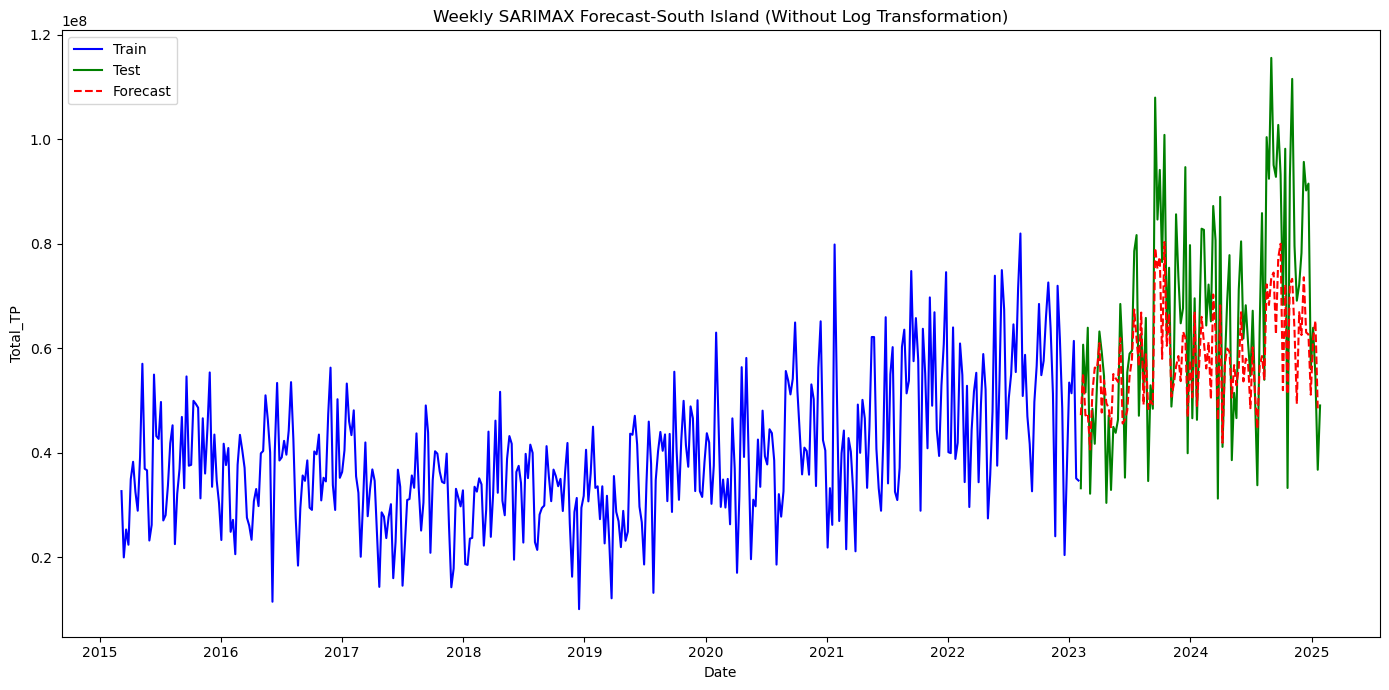

In [595]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_weekly.index, target_train, label='Train', color='blue')
plt.plot(test_weekly.index, target_test, label='Test', color='green')
plt.plot(test_weekly.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Weekly SARIMAX Forecast-South Island (Without Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

In [597]:
# # Create a log-transformed target. Adding 1 to avoid log(0) if needed.
df_tmp_wk_corr['Total_TP_log'] = np.log(df_tmp_wk_corr['Total_TP'] + 1)

In [599]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_tmp_wk_corr)
train_size = int(n * 0.8)
train_weekly_log = df_tmp_wk_corr.iloc[:train_size]
test_weekly_log = df_tmp_wk_corr.iloc[train_size:]

In [601]:
print("Weekly Train set:", train_weekly_log.index.min(), "to", train_weekly_log.index.max())
print("Weekly Test set:", test_weekly_log.index.min(), "to", test_weekly_log.index.max())

Weekly Train set: 2015-03-08 00:00:00 to 2023-01-29 00:00:00
Weekly Test set: 2023-02-05 00:00:00 to 2025-01-26 00:00:00


In [603]:
# Define the target variable (original Total_TP) and exogenous variables
target_train_log = train_weekly_log['Total_TP_log']
target_test_log = test_weekly_log['Total_TP_log']

# target_train = train_weekly['Total_TP']
# target_test = test_weekly['Total_TP']



In [605]:
exog_cols = ['WS50M','PS']
#exog_cols = ['WS50M']


In [607]:
exog_train = train_weekly_log[exog_cols]
exog_test = test_weekly_log[exog_cols]

In [609]:
# Fit SARIMAX on the original (log) target data
model_log = SARIMAX(target_train_log,
                exog=exog_train,
                order=(1, 1, 2),
                seasonal_order=(0, 1,1,52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results_log = model_log.fit(disp=False)
print(results_log.summary())

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                         Total_TP_log   No. Observations:                  413
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 52)   Log Likelihood                  58.055
Date:                              Tue, 22 Apr 2025   AIC                           -102.110
Time:                                      21:55:55   BIC                            -76.068
Sample:                                  03-08-2015   HQIC                           -91.694
                                       - 01-29-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WS50M          0.1698      0.008     21.464      0.000       0.154       0.185
PS            -0.01

In [611]:
# Forecast on the test set
n_steps_log = len(test_weekly_log)
forecast_log = results_log.get_forecast(steps=n_steps_log, exog=exog_test).predicted_mean

In [613]:
# Compute performance metrics
rmse = np.sqrt(mean_squared_error(target_test_log, forecast_log))
mae = mean_absolute_error(target_test_log, forecast_log)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test_log - forecast_log) / (target_test_log + epsilon))) * 100

print("\nForecast Performance Metrics (With Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (With Log Transformation):
RMSE: 0.20
MAE: 0.17
Adjusted MAPE: 0.93%


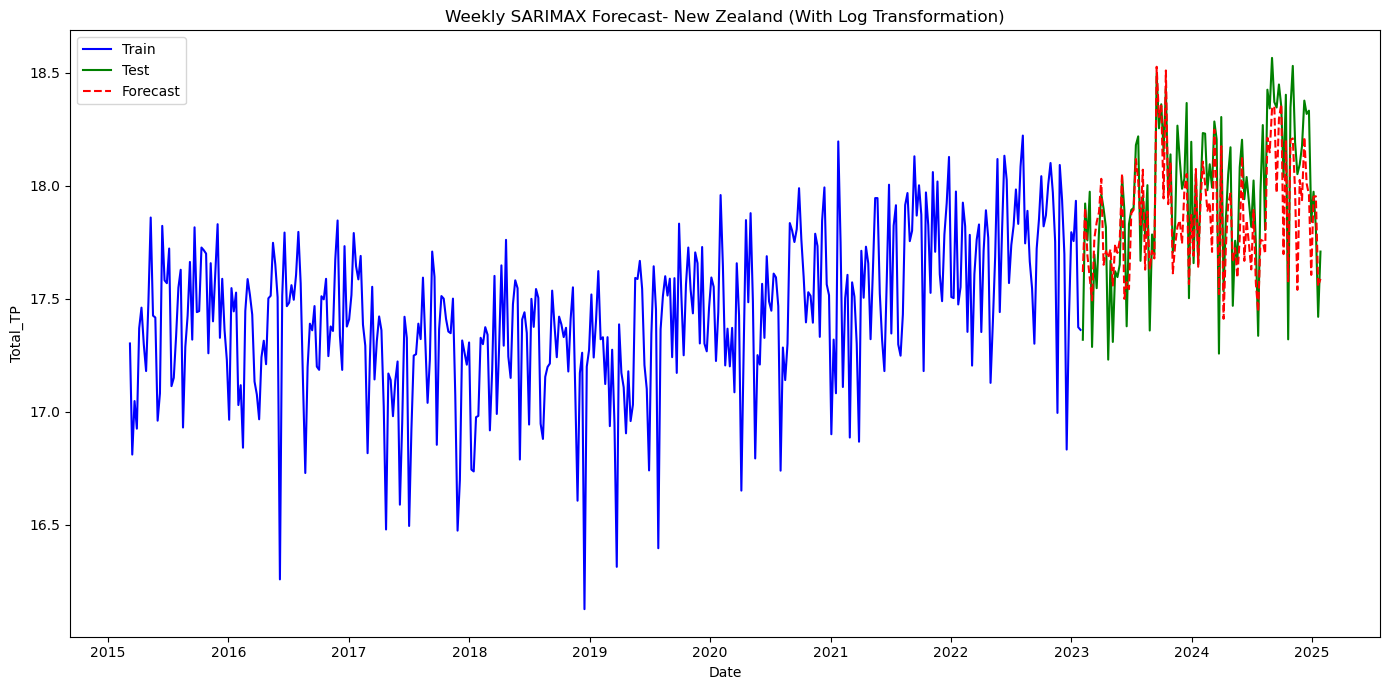

In [615]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_weekly.index, target_train_log, label='Train', color='blue')
plt.plot(test_weekly.index, target_test_log, label='Test', color='green')
plt.plot(test_weekly.index, forecast_log, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Weekly SARIMAX Forecast- New Zealand (With Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

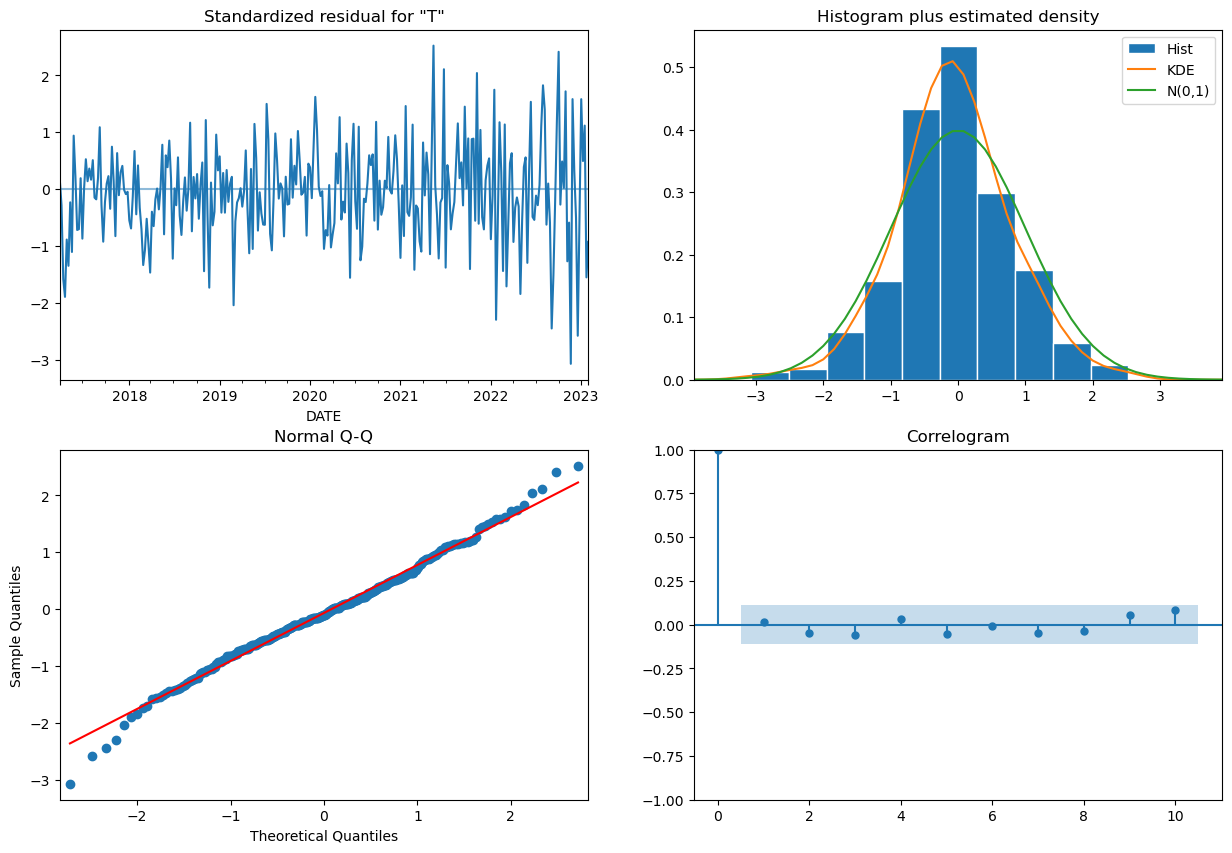

In [617]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

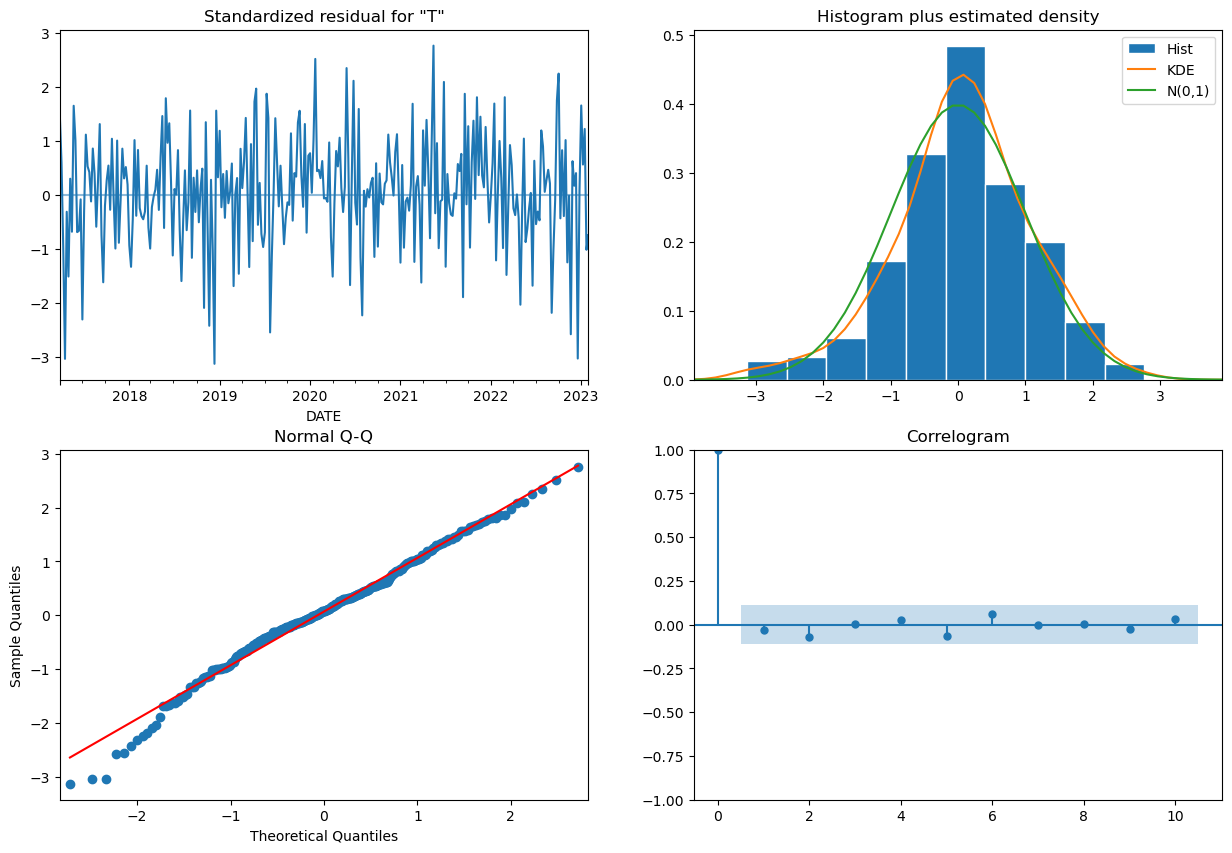

In [619]:
results_log.plot_diagnostics(figsize=(15, 10))
plt.show()